# Capstone Project - Fuck Around Notebook

- Uses TF24 environment which is not ideal.
- Play with Keras and see if it works
- Explore SpaCy entities
- Find Financial Information
- Linear Model to Predict Score
- Linear Model to Predict Reviews
- K Nearest Neighbors to Group with Similar Books
- Figure out first novel per author (year release date)
- NYT Rankings
- 

In [5]:
import pandas as pd
import numpy as np
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk import FreqDist
# from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, plot_confusion_matrix, hamming_loss
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import matplotlib.pyplot as plt
import spacy
import time
import warnings
warnings.filterwarnings('ignore')

nlp = spacy.load("en_core_web_sm")

stopwords_list = stopwords.words('english') + [' ', '  ', '   ', 'w/', 's']


def process_text(text, is_spacy=False, keep_stopwords=True):
    
    '''
    Processes, cleans, and tokenizes text with multiple options on how to do so. Returns either a SpaCy doc object or a list of tokens
    
    Parameters
    ----------
    text - (str) - the text to be processed
    is_spacy - (bool) - whether or not the return is a SpaCy doc with stop words included. If True is passed, keep_stopwords will be ignored
    keep_stopwords - (bool) - whether or not to remove stopwords using the nltk stopwords library
    keep_links - (bool) - whether or not to turn a handle and website link into a blank word such as WEBSITE for the purposes of sentence structure vectorization
    keep_hashtags - (bool) - whether or not to simply remove the # symbol from a hashtag or remove the hashtag completely
    
    Returns
    -------
    Processed text - doc, if OR list
    
    '''
    doc = nlp(text) # Turns the resulting string into a SpaCy doc object
    
    if is_spacy == True:
        return doc
    
    text = text.replace("'", '') # Removes apostrophes
    
    if keep_stopwords == False: # Makes all tokens lower case, removes punctuation and stopwords
        return [x.lower() for x in list([token.text for token in doc if token.is_punct == False and token.text.lower() not in stopwords_list])]
    else: # Does the same thing, but keeps stopwords in
        return [x.lower() for x in list([token.text for token in doc if token.is_punct == False])]

class TextSet:

    
    def __init__(self, X, y, name=None, is_spacy=False, multi_label=False, keep_stopwords=False, random_seed=42, split=.3):
        '''
        Constructs necessary attributes for the Model_Analysis object and automatically processes the X data into Holdout, 
        Train and Test sets ready for vectorization. Also proceses y into labels and sparse OHE matrices, split into Holdout, 
        Train, and Test sets. The Holdout set is 10% of the original test data.
        Parameters:
        ----------
        X : Series or Array
            The text that will be processed in a fashion determined by the other arguments. It will be split into holdout, train, and test batches for testing. 
        y : Series or Array
            The target values for the accompanying texts passed in X. Will be processed with both a label encoder and a one hot encoded sparse matrix. Must be the same dimensions as X.
        name : String
            The name of the TextSet. Used for labeling purposes during analysis.
        is_spacy : Boolean
            Whether or not the text will be processed into a SpaCy doc and will use the SpaCy vectorization method.
        keep_stopwords: Boolean
            Whether or not the processed text will include stop words
        keep_links: Boolean
            If True is passed, Twitter handles and Web URLs will be replaced with dummy words. If False, then the links will be removed completely
        keep_hashtags: Boolean
            If True is passed, the hashtag symbol will be removed, but the rest of the hashtag will remain. If False, then the entire hashtag will be removed.
        random_seed: int
            The random state used for partitioning data
        split: float
            The size of the test set when splitting data into train and test
        '''

        self.X = X
        self.y = y
        self.multi_label = multi_label
        self.name = name
        self.is_spacy = is_spacy
        self.keep_stopwords = keep_stopwords
        self.random_seed = random_seed
        self.split = split
        self.process_data()
            
    def process_data(self):
        '''
        Takes X and y and tokenizes the text based on the methods determined by the class's parameters. 
        The data is then split into a 10% holdout group, train, and test groups. The target y variable is 
        processed into labels and one hot encoded sparse matricies.
        
        Parameters
        ----------
        
        None
        
        Returns
        -------
        text : List
            A list of all processed tokens in the X column
        X_holdout_tokens : List
            Tokenized list of the X holdout group
        X_train_tokens : List
            Tokenized list of the X train group
        X_test_tokens : List
            Tokenized list of the X test group
        y_holdout_ohe : Array
            A sparse matrix of the y holdout group
        y_holdout_l : Array
            A 1D labeled array of the y train group
        y_train_ohe : Array
            A sparse matrix of the y train group
        y_train_l : Array
            A 1D labeled array of the y train group
        y_test_ohe : Array
            A sparse matrix of the y test group
        y_test_l : Array
            A 1D labeled array of the y test group
        y_ohe : OneHotEncoder
            The one hot encoder used to transform y values into sparse matricies
        y_labeler : LabelEncoder
            The label encoder used to transform the y values into the labels fo testing
        process_time 
        : int
            Amount of time in seconds for text to process
        '''
        start_time = time.time()
        
        self.tokens = [process_text(text, 
                                    is_spacy=self.is_spacy, 
                                    keep_stopwords=self.keep_stopwords) for text in self.X]
        
        
        X_processed, self.X_holdout_tokens, y_processed, self.y_holdout = train_test_split(self.tokens, 
                                                                              self.y, 
                                                                              random_state=self.random_seed, 
                                                                              test_size=.1)
        
        self.X_train_tokens, self.X_test_tokens, self.y_train, self.y_test = train_test_split(X_processed, 
                                                                              y_processed, 
                                                                              random_state=self.random_seed, 
                                                                              test_size=self.split)
        
        if self.is_spacy == True:
            token_list = []
            for doc in self.tokens:
                token_list.append([token.text for token in doc])
            self.tokens = token_list
            
        self.text = [' '.join(x) for x in self.tokens]
        
        if self.multi_label == False:
            encoder = OneHotEncoder()
            self.y_train_ohe = encoder.fit_transform(np.array(self.y_train).reshape(-1,1))
            self.y_test_ohe = encoder.transform(np.array(self.y_test).reshape(-1,1))
            self.y_holdout_ohe = encoder.transform(np.array(self.y_holdout).reshape(-1,1))
            self.y_ohe = encoder

            labeler = LabelEncoder()
            self.y_train_l = labeler.fit_transform(self.y_train)
            self.y_test_l = labeler.transform(self.y_test)
            self.y_holdout_l = labeler.transform(self.y_holdout)
            self.y_labeler = labeler

            self.y_train_ohe = self.y_train_ohe.toarray()
            self.y_test_ohe = self.y_test_ohe.toarray()
            self.y_holdout_ohe = self.y_holdout_ohe.toarray()
        else:
            pass
        
        self.process_time = time.time() - start_time
        
        print("--- %s seconds ---" % (self.process_time))
        
        
#     def word_cloud(self):
        
#         '''
#         Visualizes the entire corpus of X into a frequency wordcloud
        
#         Parameters
#         ----------
        
#         None
        
#         Returns
#         -------
        
#         wordcloud : WordCloud
#             A visualization of the wordcloud on a (6,6) graph
#         '''

#         words = ' '.join(self.text)

#         self.wordcloud = WordCloud(width = 600, height = 600,
#                         background_color ='white',
#                         min_font_size = 10).generate(words)

#         # plot the WordCloud image                       
#         plt.figure(figsize = (6, 6), facecolor = None)
#         plt.imshow(self.wordcloud)
#         plt.axis("off")
#         plt.tight_layout(pad = 0)
#         plt.title(f'Word Cloud For {self.name}')
#         plt.show()
        
    
    def plot_frequency(self, num_words = 50):
        
        '''
        Creates a bar graph of the frequencies of each token in the complete corpus of X
        
        Parameters
        ----------
        
        num_words : int
            Number of words to be displayed
            
        Returns
        -------
        
        Bar Plot : graph
            A bar plot of the most frequent words in the X corpus
        '''
    
        data_concat = []

        for tweet in self.tokens:
            data_concat += tweet

        data_freqdist = FreqDist(data_concat)

        x = []
        y = []

        for token in data_freqdist.most_common(num_words):
            x.append(token[0])
            y.append(token[1])

        plt.figure(figsize=(15, 6))
        plt.bar(x=x, height=y)
        plt.xticks(rotation=45)
        plt.xlabel('Words')
        plt.title(f'{self.name} {num_words} Most Common Words')
        plt.ylabel('Frequency')
        plt.show()
    
    def vectorize(self, method='tf_idf', max_features=300, ngram_range=(1,1)):
        
        '''
        Turns X_train, X_test, and X_holdout into vectors for processing 
        
        Parameters
        ----------
        
        method : String - 'tf_idf' or 'count'
            Method of vectorization if is_spacy is False
        max_features : int
            Number of words to be included in the count or TF-IDF vectorization
        ngram_range : tuple
            Number of words to be considered as paired for tokenization
        
        Returns
        -------
        
        X_train: Array
            A vector representation of X_train tokens
        X_test: Array
            A vector representation of X_test tokens
        X_holdout: Array
            A vector representation of X_holdout tokens
        vectorizer: CountVectorizer or TfidfVectorizer
            The vectorizer used to transform the X data
        
        '''
        
        if self.is_spacy == True:
            self.X_train = np.array([doc.vector for doc in self.X_train_tokens])
            self.X_test = np.array([doc.vector for doc in self.X_test_tokens])
            self.X_holdout = np.array([doc.vector for doc in self.X_holdout_tokens])
        
        else:
            X_train = [' '.join(x) for x in self.X_train_tokens]
            X_test = [' '.join(x) for x in self.X_test_tokens]
            X_holdout = [' '.join(x) for x in self.X_holdout_tokens]
            
            if method == 'tf_idf':
                self.vectorizor = TfidfVectorizer(max_features=max_features,ngram_range=ngram_range)
                self.X_train = self.vectorizor.fit_transform(X_train)
                self.X_test = self.vectorizor.transform(X_test)
                self.X_holdout = self.vectorizor.transform(X_holdout)
                self.X_train = self.X_train.toarray()
                self.X_test = self.X_test.toarray()
                self.X_holdout = self.X_holdout.toarray()

            elif method == 'count':
                self.vectorizor = CountVectorizer(max_features=max_features, ngram_range=(1,1))
                self.X_train = self.vectorizor.fit_transform(X_train)
                self.X_test = self.vectorizor.transform(X_test)
                self.X_holdout = self.vectorizor.transform(X_holdout)
                self.X_train = self.X_train.toarray()
                self.X_test = self.X_test.toarray()
                self.X_holdout = self.X_holdout.toarray()
                
        
    def regularize(self):
        
        '''
        Normalizes the X vectors using a StandardScaler. Ideal for usage with neural networks. Must be run after the vectorize function.
        
        Parameters
        ----------
        
        None
        
        Returns
        -------
        
        scaler: StandardScaler
            The scaler used to transform X vectors
        X_train_scaled: Array
            The scaled vector of X_train
        X_test_scaled: Array
            The scaled vector of X_test
        X_holdout_scaled: Array
            The scaled vector of X_holdout
        '''
            
        self.scaler = StandardScaler()
            
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        self.X_holdout_scaled = self.scaler.transform(self.X_holdout)

class ModelComparison:
    
    def __init__(self, pipeline, data_list, y_format='label', nn=False, name=None):
            '''
            Constructs necessary attributes for the ModelComparison object. If nn is True then y_format will be changed to 'ohe'.
            Parameters:
            ----------
            pipeline : Classifier
                An untrained classification alogorithm for comparing against data. A pipeline is recommended in order to control scaling and imputing, but a regular model can be passed.
            data_list : List
                A list of TextSet objects with X, y train, test and holdout sets already processed and vectorized
            y_format : 'label', 'ohe' or 'multi_label'
                The format of the y_data. If 'label' is passed, then y_train_l will be used. If 'ohe', then y_train_ohe will be used. Else, y_train tokens will be used.
            nn : Boolean
                Whether or not the pipeline is a neural network
            name : String
                The name of the ModelComparison Object.
            '''
            self.pipeline = pipeline
            self.data_list = data_list
            self.name = name
            self.y_format = y_format
            self.data_names = {j:i for (i, j) in tuple(enumerate([x.name for x in self.data_list]))}
            self.ref_dict = {dataset.name : dataset for dataset in self.data_list}
            self.nn = nn
            
            if self.nn == True:
                self.y_format = 'ohe'
    
    def set_model(self, new_model, y_change=None, nn_change=False):
        '''
        Changes the model used for comparison.
        
        Parameters
        ----------
        
        new_model : Classifier
            An untrained classification alogorithm for comparing against data.
        y_change : 'label', 'ohe', 'raw' or None
            The new configuration of the y variable
        nn_change : Boolean
            Pass True if the new model is a neural network, else pass False
        
        '''
        self.pipeline = new_model
        if y_change != None:
            self.y_format = y_change
        
        if nn_change == True:
            self.nn = nn_change

    def fit_models(self, data=None, batch_size=15, epochs=20):
        
        '''
        Fits the model to each of the datasets and produces data for comparison and visualization.
        
        Parameters
        ----------
        
        data : List
            A list of processed TextSet objects. If None is passed, then the model will train on every model in the ModelComparison object
        batch_size : int
            Size of batches used when training a Neural Network model. Ignored if nn is False.
        epochs : int
            Number of epochs used to train a Neural Network model. Ignored if nn is False.
            
        Returns
        -------
        
        data_dict : dictionary
            A dictionary with keys corresponding to the names of each dataset fit to the model. Contains all predicted y values for each dataset for visualization and comparison.
        score_comparison: dataframe
            A dataframe of scores for each dataframe with the maximum value in each row highlighted
        process_time: int
            Amount of time taken to fit the model to all datasets.
        '''
        
        start_time = time.time()
        self.data_dict = {}
        
        if data == None:
            set_list = self.data_list
        
        else:
            set_list = data
        
        for dataset in set_list:
            
            if self.y_format == 'multi_label':
                y_dict_train = {'multi_label': dataset.y_train}
                y_dict_test = {'multi_label': dataset.y_test}
                y_dict_holdout = {'multi_label': dataset.y_holdout}
            
            else:
                y_dict_train = {
                    'label': dataset.y_train_l,
                    'ohe': dataset.y_train_ohe,
                    'raw': dataset.y_train
                    }

                y_dict_test = {
                    'label': dataset.y_test_l,
                    'ohe': dataset.y_test_ohe,
                    'raw': dataset.y_test
                }

                y_dict_holdout = {
                    'label': dataset.y_holdout_l,
                    'ohe': dataset.y_holdout_ohe,
                    'raw': dataset.y_holdout
                }
            
            y_train = y_dict_train[self.y_format]
            y_test = y_dict_test[self.y_format]
            y_holdout = y_dict_holdout[self.y_format]
            
            if self.nn == True:
                
                model = self.pipeline.fit(dataset.X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_data=(dataset.X_train_scaled, y_train))
                
                y_train_preds = self.pipeline.predict(dataset.X_train_scaled)
                y_test_preds = self.pipeline.predict(dataset.X_test_scaled)
                y_holdout_preds = self.pipeline.predict(dataset.X_holdout_scaled)
                
                hold_val = self.pipeline.evaluate(dataset.X_holdout_scaled, y_holdout)
            
            else:
                model = self.pipeline.fit(dataset.X_train, y_train)
                
                y_train_preds = model.predict(dataset.X_train)
                y_test_preds = model.predict(dataset.X_test)
                y_holdout_preds = model.predict(dataset.X_holdout)
            
            if self.nn==False:
                
                self.data_dict[dataset.name] = {
                    'y_train': y_train,
                    'y_test': y_test,
                    'y_holdout': y_holdout,
                    'y_train_preds': y_train_preds, 
                    'y_test_preds': y_test_preds,
                    'y_holdout_preds': y_holdout_preds,   
                }
            
            else:
                self.data_dict[dataset.name] = {
                    'y_train': y_train,
                    'y_test': y_test,
                    'y_holdout': y_holdout,
                    'y_train_preds': y_train_preds, 
                    'y_test_preds': y_test_preds,
                    'y_holdout_preds': y_holdout_preds,
                    'model_history': model.history,
                    'holdout_history': hold_val
                }
        
        if self.nn == False:
            self.calc_scores(data=set_list)
        else:
            self.calc_nn_scores(data=set_list)
        self.process_time = time.time() - start_time
        print("--- %s seconds to process ---" % (self.process_time))
    
    def calc_scores(self, data=None, data_type='test'):
        
        '''
        Calculates all major scores on each dataset for comparison for non neural network datasets. Will return an error if the model is a neural network.
        
        Parameters
        ----------
        
        data : List
            A list of processed TextSet objects. If None is passed, then the model will train on every model in the ModelComparison object
        data_type : String - 'test' or 'holdout'
            Determines the values compared in the final score comparison. If 'test', then the test scores will be compared. If 'holdout', then holdout scores will be shown.
        
        Returns
        -------
        
        all_scores : DataFrame
            All train and test scores for all datasets in a single dataframe showing scores for Accuracy, Precision, Recall and F1 Score. All values are calculated using the Macro method.
        score_comparison : DataFrame
            Test scores for each dataset compared in a single dataframe with the top value in each row highlighted.
        '''
        
        df_list = []
        
        title = data_type.title()
        
        if data == None:
            set_list = self.data_list
        
        else:
            set_list = data
        
        for dataset in set_list:
            
            y_train = self.data_dict[dataset.name]['y_train']
            y_train_preds = self.data_dict[dataset.name]['y_train_preds']
        
            if data_type == 'test':
                
                y_val = self.data_dict[dataset.name]['y_test']
                y_val_preds = self.data_dict[dataset.name]['y_test_preds']
            
            elif data_type == 'holdout':
            
                y_val = self.data_dict[dataset.name]['y_holdout']
                y_val_preds = self.data_dict[dataset.name]['y_holdout_preds']
            
            if self.y_format != 'multi_label':
                dictionary = {
                    'Accuracy': [accuracy_score(y_train, y_train_preds), accuracy_score(y_val, y_val_preds)],
                    'Precision (Macro)': [precision_score(y_train, y_train_preds, average='macro'), precision_score(y_val, y_val_preds, average='macro')],
                    'Recall (Macro)': [recall_score(y_train, y_train_preds, average='macro'), recall_score(y_val, y_val_preds, average='macro')],
                    'F1 (Macro)': [f1_score(y_train, y_train_preds, average='macro'), f1_score(y_val, y_val_preds, average='macro')],
                }
            else:
                dictionary = {
                    'Accuracy': [accuracy_score(y_train, y_train_preds), accuracy_score(y_val, y_val_preds)],
                    'Precision (Macro)': [precision_score(y_train, y_train_preds, average='macro'), precision_score(y_val, y_val_preds, average='macro')],
                    'Precision (Micro)': [precision_score(y_train, y_train_preds, average='micro'), precision_score(y_val, y_val_preds, average='micro')],
                    'Recall (Macro)': [recall_score(y_train, y_train_preds, average='macro'), recall_score(y_val, y_val_preds, average='macro')],
                    'Recall (Micro)': [recall_score(y_train, y_train_preds, average='micro'), recall_score(y_val, y_val_preds, average='micro')],
                    'F1 (Micro)': [f1_score(y_train, y_train_preds, average='micro'), f1_score(y_val, y_val_preds, average='micro')],
                    'F1 (Macro)': [f1_score(y_train, y_train_preds, average='macro'), f1_score(y_val, y_val_preds, average='macro')],
                    'F1 (Samples)': [f1_score(y_train, y_train_preds, average='samples'), f1_score(y_val, y_val_preds, average='samples')],
                    'Hamming-Loss': [hamming_loss(y_train, y_train_preds), hamming_loss(y_val, y_val_preds)],
                }
            
            df = pd.DataFrame.from_dict(dictionary, orient='index', columns=[f'{dataset.name} Train',f'{dataset.name} {title}'])
            
            self.data_dict[dataset.name][f'{data_type} scores'] = df
            df_list.append(df)
        
        self.all_scores = pd.concat(df_list, axis=1)
        
        self.score_comparison = self.all_scores[[x for x in self.all_scores.columns if x.endswith(title)]]
        
        self.score_comparison = self.score_comparison.style.highlight_max(color='lightgreen', axis=1)
        
    def calc_nn_scores(self, data=None):
        
        '''
        Calculates accuracy and loss scores for each dataset if the model is a neural network. Will produce an error if the model is not a neural network.
        
        Parameters
        ----------
        
        data : List
            A list of processed TextSet objects. If None is passed, then the model will train on every model in the ModelComparison object
        
        Returns
        -------
        
        score_comparison : DataFrame
            A dataframe comparing the accuracy and loss scores on the holdout data for each dataset
        '''

        df_list = []
        
        if data == None:
            set_list = self.data_list
        
        else:
            set_list = data

        for dataset in set_list:

            hist = self.data_dict[dataset.name]['holdout_history']

            dictionary = {
                'Loss': hist[0],
                'Accuracy': hist[1]
            }

            df = pd.DataFrame.from_dict(dictionary, orient='index', columns=[f'{dataset.name} Holdout'])

            df_list.append(df)

        self.score_comparison = pd.concat(df_list, axis=1)
            
    def compare_confusion(self, data_type='test', data=None):
        
        '''
        Plots a confusion matrix for either the Test or Holdout data for each dataset. Bear in mind, it will fit the model with all of the datsets again.
        
        Parameters
        ----------
        
        data_type : String - 'test' or 'holdout'
            Determines which dataset will be used in the confusion matrix
        data : List
            A list of processed TextSet objects. If None is passed, then the model will train on every model in the ModelComparison object
            
        Returns
        -------
        
        A confusion matrix for each dataset passed in data
        '''
        
        title = data_type.title()
        
        if data == None:
            set_list = self.data_list
        
        else:
            set_list = data
        
        for dataset in set_list:
            
            X_train = dataset.X_train
            y_train = self.data_dict[dataset.name]['y_train']
            
            self.pipeline.fit(X_train, y_train)
            
            if data_type == 'train':
                X_val = dataset.X_train
                y_val = self.data_dict[dataset.name]['y_train']
            
            elif data_type == 'test':
                X_val = dataset.X_test
                y_val = self.data_dict[dataset.name]['y_test']
                
            elif data_type == 'holdout':
                X_val = dataset.X_holdout
                y_val = self.data_dict[dataset.name]['y_holdout']
        
            plot_confusion_matrix(self.pipeline, X_val, y_val, cmap=plt.cm.Blues)
            plt.title(f'{dataset.name} {title}')
            plt.show()
        
    def plot_roc_curve(self, data_type='test', include_train=True, data=None):
        
        '''
        Plots the ROC curve for the results of the model. If a multi-class model it will return an error
        
        Parameters
        ----------
        
        data_type : String - 'test' or 'holdout'
            Determines which dataset will be used in the ROC Plot
        include_train : Boolean
            If True is passed, the ROC plot will include the training data and the validation data
        data : List
            A list of processed TextSet objects. If None is passed, then all datasets will be included in the final plot.
        
        Returns
        -------
        
        A plot of the ROC curve of the train and validation data
        '''
        
        plt.figure(figsize=(7,7))
        ax = plt.gca()
        
        if data == None:
            set_list = self.data_list
        else:
            set_list = [self.ref_dict[name] for name in data]
        
        for dataset in set_list:
            if data_type == 'test':
                y_val = self.data_dict[dataset.name]['y_test']
                y_val_preds = self.data_dict[dataset.name]['y_test_preds']
            elif data_type == 'holdout':
                y_val = self.data_dict[dataset.name]['y_holdout']
                y_val_preds = self.data_dict[dataset.name]['y_holdout_preds']
            
            fpr, tpr, threshold = roc_curve(y_val, y_val_preds)
            plt.plot(fpr, tpr, label=f'{dataset.name} {data_type}', ax=ax)
            
            if include_train == True:
                y_train = self.data_dict[dataset.name]['y_train']
                y_train_preds = self.data_dict[dataset.name]['y_train_preds']
                
                fpr, tpr, threshold = roc_curve(y_train, y_train_preds)
                plt.plot(fpr, tpr, label=f'{dataset.name} train', ax=ax)
                
                
        plt.title(f'ROC Curve for {data_type} data')
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

        
    def plot_val_history(self, data=None):
        
        '''
        Plots the accuracy and loss curves for both the training and the testing data for a neural network model.
        
        Parameters
        ----------
        
        data : List
            A list of processed TextSet objects. If None is passed, then all datasets will be included in the final plots.
        
        Returns
        -------
        
        A subplot of the training and validation loss and accuracy values from the fit Neural Network model
        
        '''
        
        if data == None:
            set_list = self.data_list
        else:
            set_list = [self.ref_dict[name] for name in data]
        
        for dataset in set_list:
            history = self.data_dict[dataset.name]['model_history']
            fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12, 4))
            ax1.plot(history['val_loss'])
            ax1.plot(history['loss'])
            ax1.legend(['val_loss', 'loss'])
            ax1.set_title(f'{dataset.name} Loss')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Loss')

            ax2.plot(history['val_acc'])
            ax2.plot(history['acc'])
            ax2.legend(['val_acc', 'acc'])
            ax2.set_title(f'{dataset.name} Accuracy')
            ax2.set_xlabel('Epochs')
            ax2.set_ylabel('Accuracy')
            plt.show()

In [6]:
def match_fields(df_1_column, df_2_column, reverse=False, verbose=True):
    
    '''
    Matches values in fields from two dataframes and returns lists of the missing and matched values.
    
    Parameters
    ----------
    df_1_column - dataframe column - one of the dataframes used for comparison
    df_2_column - dataframe column - the other dataframe used for comparison
    reverse - bool - reverses the matching. Defaults to false so all values in df_1 will be tested to see if they are in df_2. If true, will reverse that logic.
    
    Returns
    -------
    missing - list - all values missing from the two dataframes
    matched - list - all values found in both dataframe columns

    Examples:
    ---------

    matched, missing = ut.match_fields(df['Column'], df_2['Column'], reverse=False)
    '''
    
    if reverse == False:
    
        names = df_1_column.unique()
        accounts = df_2_column.unique()
    
    else:
        
        names = df_2_column.unique()
        accounts = df_1_column.unique()

    missing = []
    matched = []

    for n in names:
        if n in accounts:
            matched.append(n)
        else:
            missing.append(n)

    if verbose == True:
        print('Matched: ', len(matched))
        print('Missing: ', len(missing))

    return matched, missing

In [7]:
df_aliens = pd.read_csv('data/sf_aliens.csv')

In [8]:
df_alt = pd.read_csv('data/sf_alternate_history.csv')
df_alt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1249 non-null   object 
 1   Original_Book_Title  1249 non-null   object 
 2   Author_Name          1249 non-null   object 
 3   Edition_Language     1248 non-null   object 
 4   Rating_score         1249 non-null   float64
 5   Rating_votes         1249 non-null   int64  
 6   Review_number        1249 non-null   int64  
 7   Book_Description     1248 non-null   object 
 8   Year_published       1249 non-null   int64  
 9   Genres               1249 non-null   object 
 10  url                  1249 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [9]:
df_alt_u = pd.read_csv('data/sf_alternate_universe.csv')
df_alt_u.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1247 non-null   object 
 1   Original_Book_Title  1247 non-null   object 
 2   Author_Name          1247 non-null   object 
 3   Edition_Language     1246 non-null   object 
 4   Rating_score         1247 non-null   float64
 5   Rating_votes         1247 non-null   int64  
 6   Review_number        1247 non-null   int64  
 7   Book_Description     1247 non-null   object 
 8   Year_published       1247 non-null   int64  
 9   Genres               1247 non-null   object 
 10  url                  1247 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.3+ KB


In [10]:
df_app = pd.read_csv('data/sf_apocalyptic.csv')
df_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248 entries, 0 to 1247
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1248 non-null   object 
 1   Original_Book_Title  1248 non-null   object 
 2   Author_Name          1248 non-null   object 
 3   Edition_Language     1243 non-null   object 
 4   Rating_score         1248 non-null   float64
 5   Rating_votes         1248 non-null   int64  
 6   Review_number        1248 non-null   int64  
 7   Book_Description     1244 non-null   object 
 8   Year_published       1248 non-null   int64  
 9   Genres               1248 non-null   object 
 10  url                  1248 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.4+ KB


In [11]:
df_cyber = pd.read_csv('data/sf_cyberpunk.csv')
df_cyber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1244 non-null   object 
 1   Original_Book_Title  1244 non-null   object 
 2   Author_Name          1244 non-null   object 
 3   Edition_Language     1243 non-null   object 
 4   Rating_score         1244 non-null   float64
 5   Rating_votes         1244 non-null   int64  
 6   Review_number        1244 non-null   int64  
 7   Book_Description     1226 non-null   object 
 8   Year_published       1244 non-null   int64  
 9   Genres               1244 non-null   object 
 10  url                  1244 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.0+ KB


In [12]:
df_dys = pd.read_csv('data/sf_dystopia.csv')
df_dys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1242 non-null   object 
 1   Original_Book_Title  1242 non-null   object 
 2   Author_Name          1242 non-null   object 
 3   Edition_Language     1241 non-null   object 
 4   Rating_score         1242 non-null   float64
 5   Rating_votes         1242 non-null   int64  
 6   Review_number        1242 non-null   int64  
 7   Book_Description     1241 non-null   object 
 8   Year_published       1242 non-null   int64  
 9   Genres               1242 non-null   object 
 10  url                  1242 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 106.9+ KB


In [13]:
df_hard = pd.read_csv('data/sf_hard.csv')
df_hard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1246 non-null   object 
 1   Original_Book_Title  1246 non-null   object 
 2   Author_Name          1246 non-null   object 
 3   Edition_Language     1243 non-null   object 
 4   Rating_score         1246 non-null   float64
 5   Rating_votes         1246 non-null   int64  
 6   Review_number        1246 non-null   int64  
 7   Book_Description     1219 non-null   object 
 8   Year_published       1246 non-null   int64  
 9   Genres               1246 non-null   object 
 10  url                  1246 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.2+ KB


In [14]:
df_mil = pd.read_csv('data/sf_military.csv')
df_mil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1250 non-null   object 
 1   Original_Book_Title  1250 non-null   object 
 2   Author_Name          1250 non-null   object 
 3   Edition_Language     1241 non-null   object 
 4   Rating_score         1250 non-null   float64
 5   Rating_votes         1250 non-null   int64  
 6   Review_number        1250 non-null   int64  
 7   Book_Description     1249 non-null   object 
 8   Year_published       1250 non-null   int64  
 9   Genres               1250 non-null   object 
 10  url                  1250 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [15]:
df_rob = pd.read_csv('data/sf_robots.csv')
df_rob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1250 non-null   object 
 1   Original_Book_Title  1250 non-null   object 
 2   Author_Name          1250 non-null   object 
 3   Edition_Language     1247 non-null   object 
 4   Rating_score         1250 non-null   float64
 5   Rating_votes         1250 non-null   int64  
 6   Review_number        1250 non-null   int64  
 7   Book_Description     1239 non-null   object 
 8   Year_published       1250 non-null   int64  
 9   Genres               1250 non-null   object 
 10  url                  1250 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [16]:
df_space = pd.read_csv('data/sf_space_opera.csv')
df_space.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1250 non-null   object 
 1   Original_Book_Title  1250 non-null   object 
 2   Author_Name          1250 non-null   object 
 3   Edition_Language     1247 non-null   object 
 4   Rating_score         1250 non-null   float64
 5   Rating_votes         1250 non-null   int64  
 6   Review_number        1250 non-null   int64  
 7   Book_Description     1248 non-null   object 
 8   Year_published       1250 non-null   int64  
 9   Genres               1250 non-null   object 
 10  url                  1250 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [17]:
df_steam = pd.read_csv('data/sf_steampunk.csv')
df_steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1250 non-null   object 
 1   Original_Book_Title  1250 non-null   object 
 2   Author_Name          1250 non-null   object 
 3   Edition_Language     1249 non-null   object 
 4   Rating_score         1250 non-null   float64
 5   Rating_votes         1250 non-null   int64  
 6   Review_number        1250 non-null   int64  
 7   Book_Description     1246 non-null   object 
 8   Year_published       1250 non-null   int64  
 9   Genres               1250 non-null   object 
 10  url                  1250 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [18]:
df_time = pd.read_csv('data/sf_time_travel.csv')
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248 entries, 0 to 1247
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1248 non-null   object 
 1   Original_Book_Title  1248 non-null   object 
 2   Author_Name          1248 non-null   object 
 3   Edition_Language     1244 non-null   object 
 4   Rating_score         1248 non-null   float64
 5   Rating_votes         1248 non-null   int64  
 6   Review_number        1248 non-null   int64  
 7   Book_Description     1247 non-null   object 
 8   Year_published       1248 non-null   int64  
 9   Genres               1248 non-null   object 
 10  url                  1248 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.4+ KB


In [19]:
df_aliens.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,Obsidian,Obsidian,Jennifer L. Armentrout,English,4.17,236780,18161,Starting over sucks.When we moved to West Virg...,2011,"{'Young Adult': 3439, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/12578077-o...
1,Onyx,Onyx,Jennifer L. Armentrout,English,4.27,153429,10497,BEING CONNECTED TO DAEMON BLACK SUCKS… Thanks ...,2012,"{'Young Adult': 2271, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/13047090-onyx
2,The 5th Wave,The 5th Wave,Rick Yancey,English,4.03,400600,29990,"After the 1st wave, only darkness remains. Aft...",2013,"{'Young Adult': 5436, 'Science Fiction': 3327,...",https://www.goodreads.com/book/show/16101128-t...
3,The Host,The Host,Stephenie Meyer,English,3.84,915026,41673,Melanie Stryder refuses to fade away. The eart...,2008,"{'Young Adult': 4529, 'Science Fiction': 4285,...",https://www.goodreads.com/book/show/1656001.Th...
4,Opal,Opal,Jennifer L. Armentrout,None,4.27,129006,9463,No one is like Daemon Black.When he set out to...,2012,"{'Young Adult': 1855, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/13362536-opal


In [20]:
df_alt.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,The Man in the High Castle,The Man in the High Castle,Philip K. Dick,English,3.62,180593,11895,It's America in 1962. Slavery is legal once ag...,1962,"{'Science Fiction': 4175, 'Fiction': 3446, 'Sc...",https://www.goodreads.com/book/show/216363.The...
1,His Majesty's Dragon,His Majesty's Dragon,Naomi Novik,English,4.03,83308,6588,Aerial combat brings a thrilling new dimension...,2006,"{'Fantasy': 7710, 'Fantasy (Dragons) ': 1350, ...",https://www.goodreads.com/book/show/28876.His_...
2,Leviathan,Leviathan,Scott Westerfeld,English,3.90,88293,7052,"Prince Aleksander, would-be heir to the Austro...",2009,"{'Science Fiction (Steampunk) ': 3334, 'Young ...",https://www.goodreads.com/book/show/6050678-le...
3,Jonathan Strange & Mr Norrell,Jonathan Strange & Mr Norrell,Susanna Clarke,English,3.82,206919,14397,"Sophisticated, witty, and ingeniously convinci...",2004,"{'Fantasy': 11071, 'Fiction': 3752, 'Historica...",https://www.goodreads.com/book/show/14201.Jona...
4,The Yiddish Policemen's Union,The Yiddish Policemen's Union,Michael Chabon,English,3.71,70984,6992,"For sixty years, Jewish refugees and their des...",2007,"{'Fiction': 2240, 'Mystery': 919, 'Science Fic...",https://www.goodreads.com/book/show/16703.The_...


In [21]:
df_alt_u.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,The Golden Compass,Northern Lights,Philip Pullman,English,3.99,1319185,23073,"Lyra is rushing to the cold, far North, where ...",1995,"{'Fantasy': 25101, 'Young Adult': 7903, 'Ficti...",https://www.goodreads.com/book/show/119322.The...
1,The Subtle Knife,The Subtle Knife,Philip Pullman,English,4.13,380713,10386,She had asked: What is he? A friend or an enem...,1997,"{'Fantasy': 15001, 'Young Adult': 4852, 'Ficti...",https://www.goodreads.com/book/show/41637836-t...
2,The Amber Spyglass,The Amber Spyglass,Philip Pullman,English,4.08,310788,10747,"Will is the bearer of the knife. Now, accompan...",2000,"{'Fantasy': 13544, 'Young Adult': 4410, 'Ficti...",https://www.goodreads.com/book/show/18122.The_...
3,A Darker Shade of Magic,A Darker Shade of Magic,V.E. Schwab,English,4.06,217080,27707,Kell is one of the last Antari—magicians with ...,2015,"{'Fantasy': 16223, 'Young Adult': 2309, 'Ficti...",https://www.goodreads.com/book/show/22055262-a...
4,His Majesty's Dragon,His Majesty's Dragon,Naomi Novik,English,4.03,83308,6588,Aerial combat brings a thrilling new dimension...,2006,"{'Fantasy': 7710, 'Fantasy (Dragons) ': 1350, ...",https://www.goodreads.com/book/show/28876.His_...


In [22]:
df_app.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,The Road,The Road,Cormac McCarthy,English,3.97,735303,46499,"A searing, postapocalyptic novel destined to b...",2006,"{'Fiction': 10320, 'Science Fiction': 2804, 'S...",https://www.goodreads.com/book/show/6288.The_Road
1,Station Eleven,Station Eleven,Emily St. John Mandel,English,4.05,339864,40282,"Set in the days of civilization's collapse, St...",2014,"{'Fiction': 6481, 'Science Fiction': 3572, 'Sc...",https://www.goodreads.com/book/show/20170404-s...
2,The Stand,The Stand,Stephen King,English,4.34,633906,21677,This is the way the world ends: with a nanosec...,1978,"{'Horror': 8946, 'Fiction': 5609, 'Fantasy': 2...",https://www.goodreads.com/book/show/149267.The...
3,World War Z: An Oral History of the Zombie War,World War Z: An Oral History of the Zombie War,Max Brooks,English,4.01,452598,25951,The Zombie War came unthinkably close to eradi...,2006,"{'Horror': 5829, 'Fiction': 4907, 'Horror (Zom...",https://www.goodreads.com/book/show/8908.World...
4,The Passage,The Passage,Justin Cronin,English,4.03,194650,19552,IT HAPPENED FAST.THIRTY-TWO MINUTES FOR ONE WO...,2010,"{'Horror': 3239, 'Fiction': 2439, 'Science Fic...",https://www.goodreads.com/book/show/6690798-th...


In [23]:
df_cyber.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,Neuromancer,Neuromancer,William Gibson,English,3.90,268536,9800,Hotwired to the leading edges of art and techn...,1984,"{'Science Fiction': 6796, 'Fiction': 3550, 'Sc...",https://www.goodreads.com/book/show/6088007-ne...
1,Snow Crash,Snow Crash,Neal Stephenson,English,4.02,241095,9391,"In reality, Hiro Protagonist delivers pizza fo...",1992,"{'Science Fiction': 5069, 'Fiction': 3067, 'Sc...",https://www.goodreads.com/book/show/40651883-s...
2,Count Zero,Count Zero,William Gibson,English,4.01,46114,1219,A corporate mercenary wakes in a reconstructed...,1986,"{'Science Fiction': 1480, 'Science Fiction (Cy...",https://www.goodreads.com/book/show/22200.Coun...
3,Altered Carbon,Altered Carbon,Richard K. Morgan,English,4.05,90069,5990,Four hundred years from now mankind is strung ...,2002,"{'Science Fiction': 3185, 'Fiction': 1087, 'Sc...",https://www.goodreads.com/book/show/40792913-a...
4,Mona Lisa Overdrive,Mona Lisa Overdrive,William Gibson,English,3.99,37399,957,"William Gibson, author of the extraordinary mu...",1988,"{'Science Fiction': 1337, 'Science Fiction (Cy...",https://www.goodreads.com/book/show/154091.Mon...


In [24]:
df_dys.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,The Hunger Games,The Hunger Games,Suzanne Collins,English,4.33,6570886,174054,"Could you survive on your own in the wild, wit...",2008,"{'Young Adult': 31061, 'Fiction': 17561, 'Scie...",https://www.goodreads.com/book/show/2767052-th...
1,Catching Fire,Catching Fire,Suzanne Collins,English,4.29,2605247,97929,Sparks are igniting.Flames are spreading.And t...,2009,"{'Young Adult': 26369, 'Science Fiction (Dysto...",https://www.goodreads.com/book/show/6148028-ca...
2,Mockingjay,Mockingjay,Suzanne Collins,English,4.05,2419502,102438,My name is Katniss Everdeen.Why am I not dead?...,2010,"{'Young Adult': 24914, 'Science Fiction (Dysto...",https://www.goodreads.com/book/show/7260188-mo...
3,Divergent,Divergent,Veronica Roth,English,4.19,3007473,109091,"In Beatrice Prior's dystopian Chicago world, s...",2011,"{'Young Adult': 20859, 'Science Fiction (Dysto...",https://www.goodreads.com/book/show/13335037-d...
4,1984,Nineteen Eighty-Four,George Orwell,English,4.19,3275862,73090,"Among the seminal texts of the 20th century, N...",1949,"{'Classics': 35921, 'Fiction': 22429, 'Science...",https://www.goodreads.com/book/show/40961427-1984


In [25]:
df_hard.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,The Martian,The Martian,Andy Weir,English,4.40,846623,73943,"Six days ago, astronaut Mark Watney became one...",2012,"{'Science Fiction': 12536, 'Fiction': 8948, 'A...",https://www.goodreads.com/book/show/18007564-t...
1,The Three-Body Problem,三体,Liu Cixin,English,4.06,161942,16092,The Three-Body Problem is the first chance for...,2006,"{'Science Fiction': 5069, 'Fiction': 2958, 'Cu...",https://www.goodreads.com/book/show/20518872-t...
2,Red Mars,Red Mars,Kim Stanley Robinson,English,3.86,69044,3436,"In his most ambitious project to date, award-w...",1992,"{'Science Fiction': 2848, 'Fiction': 1072, 'Sc...",https://www.goodreads.com/book/show/77507.Red_...
3,Rendezvous with Rama,Rendezvous with Rama,Arthur C. Clarke,English,4.10,137065,4159,"At first, only a few things are known about th...",1973,"{'Science Fiction': 4066, 'Fiction': 1200, 'Cl...",https://www.goodreads.com/book/show/112537.Ren...
4,Revelation Space,Revelation Space,Alastair Reynolds,English,3.98,45732,2197,"Nine hundred thousand years ago, something ann...",2000,"{'Science Fiction': 2073, 'Fiction': 499, 'Spa...",https://www.goodreads.com/book/show/89187.Reve...


In [26]:
df_mil.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,Old Man's War,Old Man's War,John Scalzi,English,4.21,168390,9719,John Perry did two things on his 75th birthday...,2005,"{'Science Fiction': 5012, 'Fiction': 1428, 'Sp...",https://www.goodreads.com/book/show/36510196-o...
1,On Basilisk Station,On Basilisk Station,David Weber,English,4.13,42410,2016,Honor Harrington in trouble: Having made him l...,1992,"{'Science Fiction': 1619, 'Space (Space Opera)...",https://www.goodreads.com/book/show/35921.On_B...
2,Dauntless,"Dauntless (The Lost Fleet, #1)",Jack Campbell,English,3.96,27813,1584,The Alliance has been fighting the Syndics for...,2006,"{'Science Fiction': 1098, 'Space (Space Opera)...",https://www.goodreads.com/book/show/112292.Dau...
3,The Forever War,The Forever War,Joe Haldeman,English,4.14,143487,6003,The Earth's leaders have drawn a line in the i...,1974,"{'Science Fiction': 4396, 'Fiction': 1449, 'Wa...",https://www.goodreads.com/book/show/21611.The_...
4,Starship Troopers,Starship Troopers,Robert A. Heinlein,English,4.00,197451,5765,The historians can’t seem to settle whether to...,1959,"{'Science Fiction': 4491, 'Fiction': 1570, 'Cl...",https://www.goodreads.com/book/show/17214.Star...


In [27]:
df_rob.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,"I, Robot","I, Robot",Isaac Asimov,English,4.20,283084,6971,"Isaac Asimov's I, Robot launches readers on an...",1950,"{'Science Fiction': 6502, 'Fiction': 2523, 'Cl...",https://www.goodreads.com/book/show/41804.I_Robot
1,The Caves of Steel,The Caves of Steel,Isaac Asimov,English,4.17,80834,2799,A millennium into the future two advancements ...,1954,"{'Science Fiction': 3128, 'Fiction': 879, 'Mys...",https://www.goodreads.com/book/show/41811.The_...
2,All Systems Red,All Systems Red,Martha Wells,English,4.15,81820,10028,"In a corporate-dominated spacefaring future, p...",2017,"{'Science Fiction': 3821, 'Fiction': 1301, 'No...",https://www.goodreads.com/book/show/32758901-a...
3,Robopocalypse,Robopocalypse,Daniel H. Wilson,English,3.69,36558,4234,"In the near future, at a moment no one will no...",2011,"{'Science Fiction': 1204, 'Fiction': 508, 'Apo...",https://www.goodreads.com/book/show/9634967-ro...
4,Do Androids Dream of Electric Sheep,Do Androids Dream of Electric Sheep?,Philip K. Dick,English,4.08,359605,13609,"It was January 2021, and Rick Deckard had a li...",1968,"{'Science Fiction': 8457, 'Fiction': 4314, 'Cl...",https://www.goodreads.com/book/show/36402034-d...


In [28]:
df_steam.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,Soulless,Soulless,Gail Carriger,English,3.89,103772,10275,Alexia Tarabotti is laboring under a great man...,2009,"{'Science Fiction (Steampunk) ': 4834, 'Fantas...",https://www.goodreads.com/book/show/6381205-so...
1,Leviathan,Leviathan,Scott Westerfeld,English,3.90,88260,7052,"Prince Aleksander, would-be heir to the Austro...",2009,"{'Science Fiction (Steampunk) ': 3333, 'Young ...",https://www.goodreads.com/book/show/6050678-le...
2,Changeless,Changeless,Gail Carriger,English,3.99,42515,3943,"Alexia Maccon, the Lady Woolsey, awakens in th...",2010,"{'Science Fiction (Steampunk) ': 3138, 'Fantas...",https://www.goodreads.com/book/show/6933876-ch...
3,Boneshaker,Boneshaker,Cherie Priest,English,3.52,32012,4097,"In the early days of the Civil War, rumors of ...",2009,"{'Science Fiction (Steampunk) ': 2859, 'Fantas...",https://www.goodreads.com/book/show/1137215.Bo...
4,Blameless,Blameless,Gail Carriger,English,3.99,37506,2887,Quitting her husband's house and moving back ...,2010,"{'Science Fiction (Steampunk) ': 2803, 'Fantas...",https://www.goodreads.com/book/show/7719355-bl...


In [29]:
df_space.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,Leviathan Wakes,Leviathan Wakes,James S.A. Corey,English,4.25,181488,12298,"Humanity has colonized the solar system—Mars, ...",2011,"{'Science Fiction': 5792, 'Fiction': 1950, 'Sp...",https://www.goodreads.com/book/show/8855321-le...
1,Ancillary Justice,Ancillary Justice,Ann Leckie,English,3.97,85505,8694,"On a remote, icy planet, the soldier known as ...",2013,"{'Science Fiction': 4088, 'Fiction': 1327, 'Sp...",https://www.goodreads.com/book/show/17333324-a...
2,Caliban's War,Caliban's War,James S.A. Corey,English,4.34,102557,5808,"We are not alone.On Ganymede, breadbasket of t...",2012,"{'Science Fiction': 3129, 'Fiction': 976, 'Spa...",https://www.goodreads.com/book/show/12591698-c...
3,"The Long Way to a Small, Angry Planet","The Long Way to a Small, Angry Planet",Becky Chambers,English,4.15,80639,12511,Follow a motley crew on an exciting journey th...,2014,"{'Science Fiction': 4289, 'Fiction': 1326, 'LG...",https://www.goodreads.com/book/show/22733729-t...
4,Dune,Dune,Frank Herbert,English,4.23,815463,26256,"Set on the desert planet Arrakis, Dune is the ...",1965,"{'Science Fiction': 13877, 'Fiction': 7372, 'F...",https://www.goodreads.com/book/show/44767458-dune


In [30]:
df_time.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,Outlander,Outlander,Diana Gabaldon,English,4.23,852563,46268,"The year is 1945. Claire Randall, a former com...",1991,"{'Historical (Historical Fiction) ': 11192, 'R...",https://www.goodreads.com/book/show/10964.Outl...
1,The Time Traveler's Wife,The Time Traveler's Wife,Audrey Niffenegger,English,3.98,1604511,47705,"A funny, often poignant tale of boy meets girl...",2003,"{'Fiction': 10255, 'Romance': 5903, 'Fantasy':...",https://www.goodreads.com/book/show/18619684-t...
2,11/22/63,Eleven twenty-two sixty-three,Stephen King,English,4.31,434183,38801,Jake Epping is a thirty-five-year-old high sch...,2011,"{'Fiction': 5134, 'Historical (Historical Fict...",https://www.goodreads.com/book/show/10644930-1...
3,Dragonfly in Amber,Dragonfly in Amber,Diana Gabaldon,English,4.32,294887,15200,From the author of Outlander... a magnificent ...,1992,"{'Historical (Historical Fiction) ': 6068, 'Ro...",https://www.goodreads.com/book/show/5364.Drago...
4,Rubinrot,Rubinrot,Kerstin Gier,German,4.09,118940,10146,"Manchmal ist es ein echtes Kreuz, in einer Fam...",2009,"{'Fantasy': 3411, 'Young Adult': 2650, 'Scienc...",https://www.goodreads.com/book/show/6325285-ru...


In [31]:
df_time['Genres'].nunique()

1248

In [32]:
genre_list = [
    'aliens',
    'alternate_history',
    'alternate_universe',
    'apocalyptic',
    'cyberpunk',
    'dystopia',
    'hard',
    'military',
    'robots',
    'space_opera',
    'steampunk',
    'time_travel'
]

df_list = []

for genre in genre_list:
    df = pd.read_csv(f'data/sf_{genre}.csv')
    df.drop_duplicates(subset=['Book_Title','Author_Name'],inplace=True)
    df[f'{genre}'] = 1
    df_list.append(df)

df_books = pd.concat(df_list)

In [33]:
len(df_books)

14950

In [34]:
genre_score = df_books[['Book_Title','Author_Name'] + [genre for genre in genre_list]].groupby(['Book_Title','Author_Name']).sum()

In [35]:
df_books = df_books.drop(columns=[genre for genre in genre_list]).drop_duplicates(subset=['Book_Title','Author_Name'])

In [36]:
df_desc = df_books.merge(genre_score, how='inner', on=['Book_Title','Author_Name'])

In [37]:
df_desc = df_desc.dropna(subset=['Book_Description'])

In [38]:
df_desc.describe()

,Rating_score,Rating_votes,Review_number,Year_published,aliens,alternate_history,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel
count,11025.000000,1.102500e+04,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000
mean,3.923708,2.529002e+04,1355.155193,2001.996825,0.113197,0.113107,0.113107,0.112834,0.111111,0.112562,0.110385,0.113288,0.112200,0.111837,0.113016,0.113016
std,0.296662,1.684630e+05,5403.296914,100.414819,0.316848,0.316737,0.316737,0.316405,0.314284,0.316071,0.313384,0.316959,0.315626,0.315180,0.316627,0.316627
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.730000,6.620000e+02,55.000000,2004.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.930000,2.037000e+03,163.000000,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.130000,7.387000e+03,597.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,7.336299e+06,174079.000000,2021.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
df_desc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11025 entries, 0 to 11094
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           11025 non-null  object 
 1   Original_Book_Title  11025 non-null  object 
 2   Author_Name          11025 non-null  object 
 3   Edition_Language     11000 non-null  object 
 4   Rating_score         11025 non-null  float64
 5   Rating_votes         11025 non-null  int64  
 6   Review_number        11025 non-null  int64  
 7   Book_Description     11025 non-null  object 
 8   Year_published       11025 non-null  int64  
 9   Genres               11025 non-null  object 
 10  url                  11025 non-null  object 
 11  aliens               11025 non-null  float64
 12  alternate_history    11025 non-null  float64
 13  alternate_universe   11025 non-null  float64
 14  apocalyptic          11025 non-null  float64
 15  cyberpunk            11025 non-null 

In [36]:
tokens = nlp.pipe(df_desc['Book_Description'])

In [39]:
# list(tokens)

In [40]:
words = ' '.join(list(df_desc['Book_Description']))

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(words)

# plot the WordCloud image                       
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title(f'Word Cloud For Descriptions')
plt.show()

NameError: name 'WordCloud' is not defined

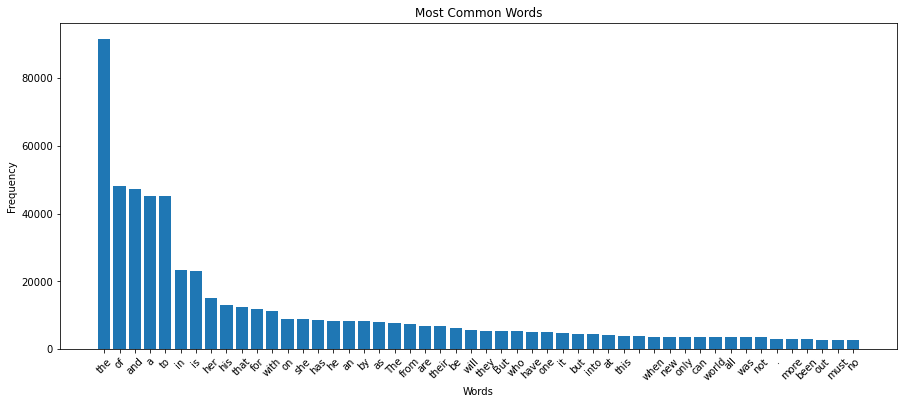

In [41]:
words = ' '.join(list(df_desc['Book_Description']))
tokens = words.split(' ')

data_freqdist = FreqDist(tokens)

x = []
y = []

for token in data_freqdist.most_common(50):
    x.append(token[0])
    y.append(token[1])

plt.figure(figsize=(15, 6))
plt.bar(x=x, height=y)
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.title(f'Most Common Words')
plt.ylabel('Frequency')
plt.show()

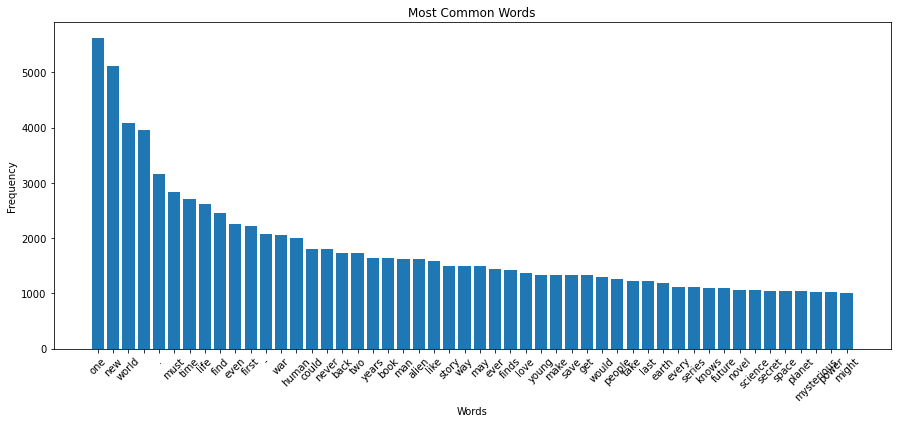

In [42]:
clean_tokens = [word.lower() for word in tokens if word.lower() not in stopwords_list]

data_freqdist = FreqDist(clean_tokens)

x = []
y = []

for token in data_freqdist.most_common(50):
    x.append(token[0])
    y.append(token[1])

plt.figure(figsize=(15, 6))
plt.bar(x=x, height=y)
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.title(f'Most Common Words')
plt.ylabel('Frequency')
plt.show()

In [43]:
test_df = df_desc.sample(n=15)
str(test_df['Book_Description'])

"2561     The second incredible book in The Keys to the ...\n10502    Two teenagers catapulted back in time to alter...\n10094    The war with the Wasp Empire has ended in a bi...\n1452     The Scourge of God is a novel of The Change se...\n679      To save her people, Mikayla S'Apul has only tw...\n10689    During a magical storm, romance writer Alaina ...\n10495    Word count: 77,000What would you do if you sud...\n9378     Suspended by chains over a seemingly bottomles...\n6279     W. Warren Wagar's A Short History of the Futur...\n554      Being a Jutak warrior is all Kyele Bastien car...\n3309     Welcome to the City of Sin, where casino famil...\n6226     The River of Time brings together eleven short...\n1939     Colonel Andrew Keane and his blue-coated soldi...\n4952     Before the Internet became widely known as a g...\n3085     My name is John Taylor. I’m a PI for hire in t...\nName: Book_Description, dtype: object"

In [44]:
x = test_df['Book_Description'].iloc[0]

In [45]:
x

"The second incredible book in The Keys to the Kingdom, now in hardcover Arthur doesn't think he will ever have to return to the strange house that nearly killed him on Monday -- the house that contains an entire world. But Tuesday brings new challenges -- in the form of an enemy named Grim Tuesday, who threatens the well-being of both Arthur's family and his world. Arthur must retrieve the Second Key from Grim Tuesday in order to save everything -- an adventure that will include stealing a Sunship, surviving a very weird work camp, befriending a bearlike spirit, fighting the voidlike Nithlings, and traveling to the scary Far Reaches for the ultimate showdown."

In [46]:
doc = nlp(x)

In [47]:
doc.ents

(second,
 The Keys to the Kingdom,
 Arthur,
 Monday,
 Tuesday,
 Grim Tuesday,
 Arthur,
 Arthur,
 the Second Key,
 Grim Tuesday,
 Nithlings,
 Far Reaches)

In [48]:
pd.options.display.max_columns=50
pd.options.display.max_rows=1000

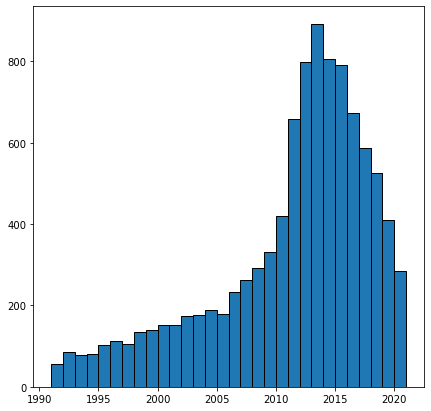

In [49]:
x = df_desc[df_desc['Year_published'] > 1990]['Year_published']
plt.figure(figsize=(7,7))
plt.hist(x=x, bins=30, edgecolor='black')
plt.show()

In [50]:
def number_genres(x):
    
    answer = 0
    
    for genre in genre_list:
        answer += x[f'{genre}']
    
    return answer

In [51]:
df_desc['Num_Genres'] = df_desc.apply(number_genres, axis=1)

In [52]:
df_desc['Num_Genres'].value_counts()

1.0    8475
2.0    1730
3.0     530
4.0     176
5.0      64
6.0      29
7.0      12
8.0       8
9.0       1
Name: Num_Genres, dtype: int64

In [53]:
df_desc[df_desc['Num_Genres'] == 9]

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url,aliens,alternate_history,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel,Num_Genres
15,The Hitchhiker's Guide to the Galaxy,The Hitchhiker's Guide to the Galaxy,Douglas Adams,English,4.22,1484282,31208,Seconds before the Earth is demolished to make...,1979,"{'Science Fiction': 14431, 'Fiction': 10469, '...",https://www.goodreads.com/book/show/386162.The...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,9.0


In [54]:
df_desc['Review_number'].describe()

count     11025.000000
mean       1355.155193
std        5403.296914
min           0.000000
25%          55.000000
50%         163.000000
75%         597.000000
max      174079.000000
Name: Review_number, dtype: float64

In [55]:
df_desc[df_desc['Review_number'] > 100000]

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url,aliens,alternate_history,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel,Num_Genres
1536,The Hunger Games,The Hunger Games,Suzanne Collins,English,4.33,6572148,174079,"Could you survive on your own in the wild, wit...",2008,"{'Young Adult': 31089, 'Fiction': 17571, 'Scie...",https://www.goodreads.com/book/show/2767052-th...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0
1839,Mockingjay,Mockingjay,Suzanne Collins,English,4.00,2012173,101751,My name is Katniss Everdeen.Why am I not dead?...,2010,"{'Young Adult': 24917, 'Science Fiction (Dysto...",https://www.goodreads.com/book/show/7260188-mo...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2005,Divergent,Divergent,Veronica Roth,English,4.19,3008156,109103,"In Beatrice Prior's dystopian Chicago world, s...",2011,"{'Young Adult': 20861, 'Science Fiction (Dysto...",https://www.goodreads.com/book/show/13335037-d...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2540,Harry Potter and the Sorcerer's Stone,Harry Potter and the Philosopher's Stone,J.K. Rowling,English,4.48,7336299,116268,Harry Potter's life is miserable. His parents ...,1997,"{'Fantasy': 63272, 'Fiction': 18715, 'Young Ad...",https://www.goodreads.com/book/show/3.Harry_Po...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [56]:
z = df_desc['Genres'].iloc[0]

In [57]:
z

"{'Young Adult': 3439, 'Fantasy (Paranormal) ': 2652, 'Fantasy': 2545, 'Romance': 2507, 'Science Fiction (Aliens) ': 1648, 'Science Fiction': 1170, 'Romance (Paranormal Romance) ': 849, 'Fantasy (Supernatural) ': 494, 'Fantasy (Urban Fantasy) ': 411, 'Fiction': 347}"

In [58]:
z.replace('{','')

"'Young Adult': 3439, 'Fantasy (Paranormal) ': 2652, 'Fantasy': 2545, 'Romance': 2507, 'Science Fiction (Aliens) ': 1648, 'Science Fiction': 1170, 'Romance (Paranormal Romance) ': 849, 'Fantasy (Supernatural) ': 494, 'Fantasy (Urban Fantasy) ': 411, 'Fiction': 347}"

In [59]:
z.split("'")

['{',
 'Young Adult',
 ': 3439, ',
 'Fantasy (Paranormal) ',
 ': 2652, ',
 'Fantasy',
 ': 2545, ',
 'Romance',
 ': 2507, ',
 'Science Fiction (Aliens) ',
 ': 1648, ',
 'Science Fiction',
 ': 1170, ',
 'Romance (Paranormal Romance) ',
 ': 849, ',
 'Fantasy (Supernatural) ',
 ': 494, ',
 'Fantasy (Urban Fantasy) ',
 ': 411, ',
 'Fiction',
 ': 347}']

In [60]:
def find_genre(entry):

    split = entry.split("'")

    genres = []

    for n in range(len(split)):
        if n%2==1:
            genres.append(split[n])

    return genres

In [61]:
df_desc['genres'] = df_desc['Genres'].map(lambda x: find_genre(x))

In [62]:
df_desc['genres']

0        [Young Adult, Fantasy (Paranormal) , Fantasy, ...
1        [Young Adult, Fantasy (Paranormal) , Romance, ...
2        [Young Adult, Science Fiction, Science Fiction...
3        [Young Adult, Science Fiction, Fantasy, Romanc...
4        [Young Adult, Fantasy (Paranormal) , Romance, ...
                               ...                        
11090    [Romance (Historical Romance) , Science Fictio...
11091    [Fantasy, Childrens, Fiction, Historical (Hist...
11092    [Romance, Science Fiction (Time Travel) , Roma...
11093    [Fiction, Historical (Historical Fiction) , No...
11094    [Fantasy, Fiction, Childrens, Childrens (Middl...
Name: genres, Length: 11025, dtype: object

In [63]:
lst = []

for x in df_desc['genres']:
    lst.extend(x)

unique_list = set(lst)

In [64]:
len(unique_list)

523

In [65]:
def age_group(x):

    if 'Children' in x:
        return 'Children'
    elif 'Young Adult' in x:
        return 'Young Adult'
    else:
        return 'Adult'

In [66]:
df_desc['Age_Group'] = df_desc['Genres'].map(lambda x: age_group(x))

In [67]:
df_desc['Age_Group'].value_counts(normalize=True)

Adult          0.727619
Young Adult    0.199637
Children       0.072744
Name: Age_Group, dtype: float64

In [68]:
labeler = LabelEncoder()

In [69]:
df_desc.columns

Index(['Book_Title', 'Original_Book_Title', 'Author_Name', 'Edition_Language',
       'Rating_score', 'Rating_votes', 'Review_number', 'Book_Description',
       'Year_published', 'Genres', 'url', 'aliens', 'alternate_history',
       'alternate_universe', 'apocalyptic', 'cyberpunk', 'dystopia', 'hard',
       'military', 'robots', 'space_opera', 'steampunk', 'time_travel',
       'Num_Genres', 'genres', 'Age_Group'],
      dtype='object')

## Model 1: Age Group

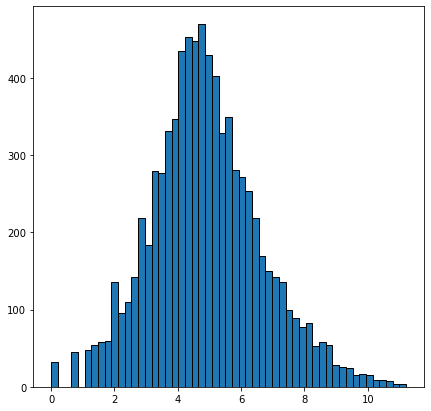

In [70]:
y = [np.log1p(x) for x in df_desc[df_desc['Age_Group'] == 'Adult']['Review_number']]
plt.figure(figsize=(7,7))
plt.hist(y, bins='auto', edgecolor='black')
plt.show()

In [71]:
df_desc[df_desc['Age_Group'] == 'Adult'].describe()

,Rating_score,Rating_votes,Review_number,Year_published,aliens,alternate_history,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel,Num_Genres
count,8022.000000,8.022000e+03,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000
mean,3.926234,1.520380e+04,803.499252,2001.084144,0.119920,0.119172,0.077911,0.101970,0.137871,0.054226,0.142359,0.151085,0.088631,0.136998,0.094490,0.104961,1.329594
std,0.298510,9.859334e+04,3391.949178,98.948937,0.324888,0.324011,0.268048,0.302627,0.344786,0.226477,0.349439,0.358154,0.284228,0.343867,0.292528,0.306523,0.751888
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.730000,5.592500e+02,43.000000,2002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.940000,1.575000e+03,115.000000,2011.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,4.140000,4.908750e+03,375.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,5.000000,3.276673e+06,73943.000000,2021.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000


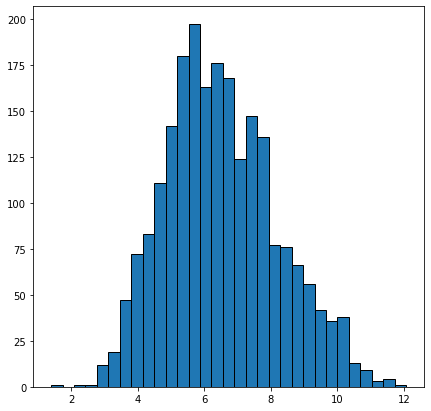

In [72]:
y = [np.log1p(x) for x in df_desc[df_desc['Age_Group'] == 'Young Adult']['Review_number']]
plt.figure(figsize=(7,7))
plt.hist(y, bins='auto', edgecolor='black')
plt.show()

In [73]:
df_desc[df_desc['Age_Group'] == 'Young Adult'].describe()

,Rating_score,Rating_votes,Review_number,Year_published,aliens,alternate_history,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel,Num_Genres
count,2201.000000,2.201000e+03,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000
mean,3.913285,4.309569e+04,3035.430713,2006.315766,0.098137,0.108587,0.207633,0.185370,0.050432,0.341663,0.030441,0.016356,0.088142,0.058155,0.182190,0.125398,1.492503
std,0.292804,2.139555e+05,8657.940568,105.193548,0.297568,0.311191,0.405705,0.388686,0.218884,0.474375,0.171836,0.126870,0.283565,0.234090,0.386089,0.331244,0.933256
min,2.500000,9.000000e+00,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.720000,1.663000e+03,201.000000,2011.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.900000,5.003000e+03,578.000000,2013.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,4.120000,1.846300e+04,2024.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,4.820000,6.572148e+06,174079.000000,2021.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000


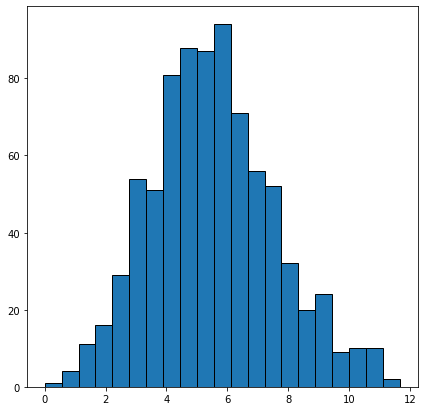

In [74]:
y = [np.log1p(x) for x in df_desc[df_desc['Age_Group'] == 'Children']['Review_number']]
plt.figure(figsize=(7,7))
plt.hist(y, bins='auto', edgecolor='black')
plt.show()

In [75]:
df_desc[df_desc['Age_Group'] == 'Children'].describe()

,Rating_score,Rating_votes,Review_number,Year_published,aliens,alternate_history,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel,Num_Genres
count,802.000000,8.020000e+02,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000
mean,3.927045,7.731158e+04,2261.760599,1999.273067,0.087282,0.064838,0.205736,0.022444,0.009975,0.067332,0.009975,0.001247,0.413965,0.007481,0.108479,0.159601,1.158354
std,0.288246,4.036289e+05,8312.096194,101.336593,0.282424,0.246393,0.404490,0.148215,0.099438,0.250752,0.099438,0.035311,0.492850,0.086224,0.311178,0.366464,0.493262
min,2.710000,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.780000,4.255000e+02,64.000000,1999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.940000,2.605000e+03,217.000000,2009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,4.120000,1.548650e+04,893.750000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,4.620000,7.336299e+06,116268.000000,2021.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


In [76]:
import seaborn as sns

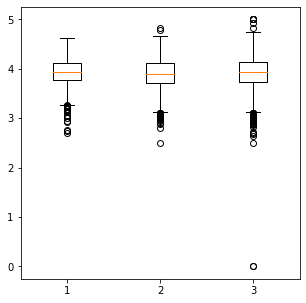

In [77]:
data = []
for age in ['Children','Young Adult','Adult']:
    x = df_desc[df_desc['Age_Group']==age]['Rating_score']
    data.append(x)

fig, ax = plt.subplots(figsize=(5,5))
ax.boxplot(data)
plt.show()


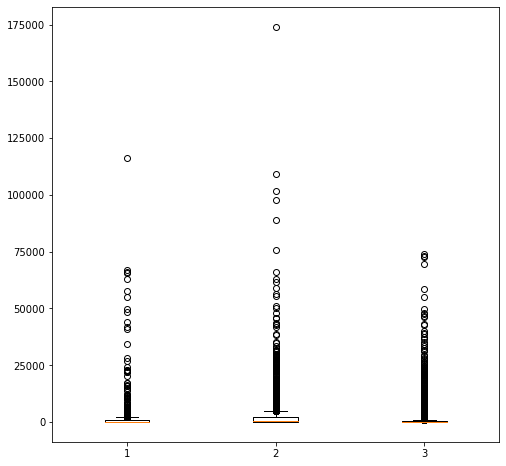

In [78]:
data = []
for age in ['Children','Young Adult','Adult']:
    x = df_desc[df_desc['Age_Group']==age]['Review_number']
    data.append(x)

fig, ax = plt.subplots(figsize=(8,8))
ax.boxplot(data)
plt.show()


In [79]:
spacy_1 = TextSet(X=df_desc['Book_Description'],
                  y=df_desc['Age_Group'],
                  name = 'SpaCy 1',
                  is_spacy=True, 
                  keep_stopwords=True, 
                  random_seed=42)

KeyboardInterrupt: 

In [ ]:
tf_idf = TextSet(X=df_desc['Book_Description'],
                 y=df_desc['Age_Group'],
                 name='tf-idf_1',
                 is_spacy=False, 
                 keep_stopwords=False)

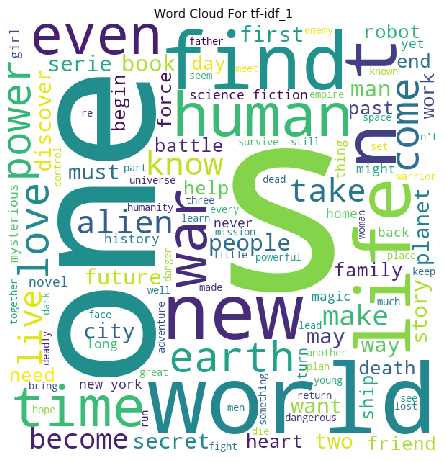

In [80]:
tf_idf.word_cloud()

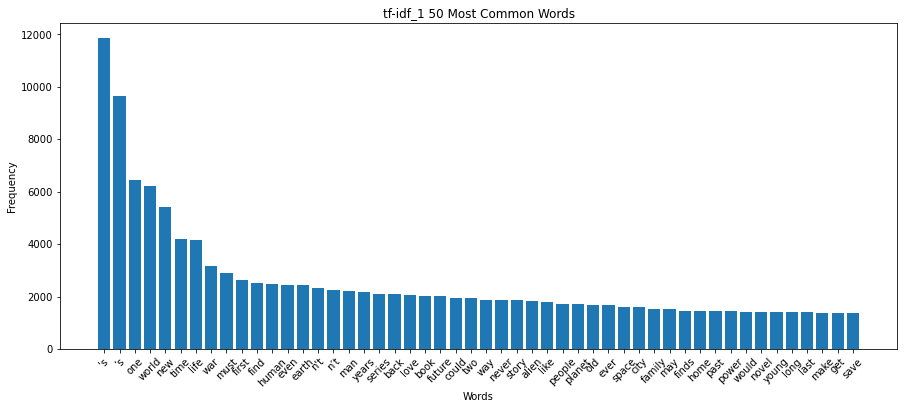

In [79]:
tf_idf.plot_frequency()

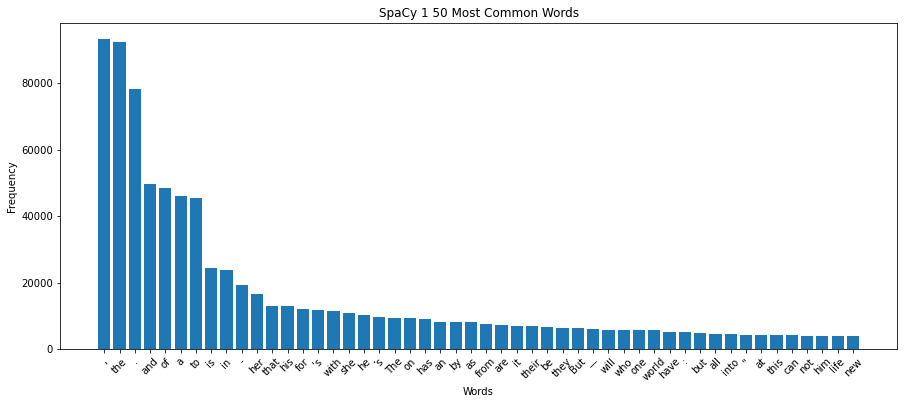

In [80]:
spacy_1.plot_frequency()

In [81]:
spacy_1.vectorize()
tf_idf.vectorize()

In [82]:
data = [spacy_1, tf_idf]

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [84]:
svm_pipe = Pipeline([('scaler', StandardScaler()), ('rbf',svm.SVC())])

grid= {
    'rbf__kernel':['rbf'],
    'rbf__gamma' :['scale','auto'],
    'rbf__C': [1, 1e12],
    'rbf__decision_function_shape': ['ovo','ovr']
}

svm_grid = GridSearchCV(svm_pipe, param_grid=grid, scoring='accuracy',cv=5)
svm_compare = ModelComparison(pipeline=svm_grid, data_list=data, y_format='label',name='svm')

In [85]:
svm_compare.fit_models()
svm_compare.score_comparison
svm_compare.pipeline.best_params_

--- 551.4518249034882 seconds to process ---


{'rbf__C': 1000000000000.0,
 'rbf__decision_function_shape': 'ovo',
 'rbf__gamma': 'auto',
 'rbf__kernel': 'rbf'}

In [ ]:
svm_compare.calc_scores(data_type='holdout')
svm_compare.score_comparison

In [87]:
svm_compare_2 = ModelComparison(pipeline=svm_pipe, data_list=data, y_format='label',name='svm')
svm_compare_2.fit_models()
svm_compare_2.score_comparison

--- 30.023403644561768 seconds to process ---


,SpaCy 1 Test,tf-idf_1 Test
Accuracy,0.721196,0.759825
Precision (Macro),0.434440,0.720876
Recall (Macro),0.341065,0.438811
F1 (Macro),0.297305,0.461978


## Next Steps
- Build Neural Net model
- Mess with tokenization methods
- Check out other ways to process text
- Find more data to add in (fantasy? Wikipedia?)
- Build multiple graphs showing data trends
- Reduce dataset to last 10 years
- Reduce dataset to debut novels
- Build a linear regression for score
- Build a linear regression for number of votes (popularity)
- Play with genre detector
- Play with SpaCy pipe

In [90]:
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Dropout, Layer

In [91]:
spacy_1_nn = TextSet(X=df_desc['Book_Description'],
                  y=df_desc['Age_Group'],
                  name = 'SpaCy 1',
                  is_spacy=True, 
                  keep_stopwords=True, 
                  random_seed=42)

--- 238.54214811325073 seconds ---


In [92]:
tf_idf_nn = TextSet(X=df_desc['Book_Description'],
                 y=df_desc['Age_Group'],
                 name='tf-idf_1',
                 is_spacy=False, 
                 keep_stopwords=False)

--- 234.61091780662537 seconds ---


In [93]:
model_spacy = Sequential()

model_spacy.add(Dense(75, activation='relu', input_shape=(96,)))
model_spacy.add(Dense(50, activation='relu'))
model_spacy.add(Dense(3, activation='softmax'))

model_spacy.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [94]:
model_tfidf = Sequential()

model_tfidf.add(Dense(75, activation='relu', input_shape=(300,)))
model_tfidf.add(Dense(50, activation='relu'))
model_tfidf.add(Dense(3, activation='softmax'))

model_tfidf.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [95]:
spacy_1_nn.vectorize()
spacy_1_nn.regularize()

tf_idf_nn.vectorize()
tf_idf_nn.regularize()

In [96]:
nn_compare_s = ModelComparison(pipeline=model_spacy, data_list=[spacy_1_nn], y_format='ohe', name='nn_spacy', nn=True)
nn_compare_tf = ModelComparison(pipeline=model_tfidf, data_list=[tf_idf_nn], y_format='ohe', name='nn_tfidf', nn=True)

In [97]:
nn_compare_s.fit_models()

Epoch 1/20
463/463 [==============================] - 17s 3ms/step - loss: 0.7726 - acc: 0.6836 - val_loss: 0.6333 - val_acc: 0.7611
Epoch 2/20
463/463 [==============================] - 1s 2ms/step - loss: 0.6401 - acc: 0.7486 - val_loss: 0.5765 - val_acc: 0.7708
Epoch 3/20
463/463 [==============================] - 1s 2ms/step - loss: 0.5895 - acc: 0.7651 - val_loss: 0.5474 - val_acc: 0.7784
Epoch 4/20
463/463 [==============================] - 1s 2ms/step - loss: 0.5622 - acc: 0.7797 - val_loss: 0.5049 - val_acc: 0.7952
Epoch 5/20
463/463 [==============================] - 1s 2ms/step - loss: 0.5184 - acc: 0.7908 - val_loss: 0.4779 - val_acc: 0.8069
Epoch 6/20
463/463 [==============================] - 1s 2ms/step - loss: 0.4955 - acc: 0.8010 - val_loss: 0.4518 - val_acc: 0.8235
Epoch 7/20
463/463 [==============================] - 1s 2ms/step - loss: 0.4675 - acc: 0.8157 - val_loss: 0.4188 - val_acc: 0.8301
Epoch 8/20
463/463 [==============================] - 1s 2ms/step - loss: 0

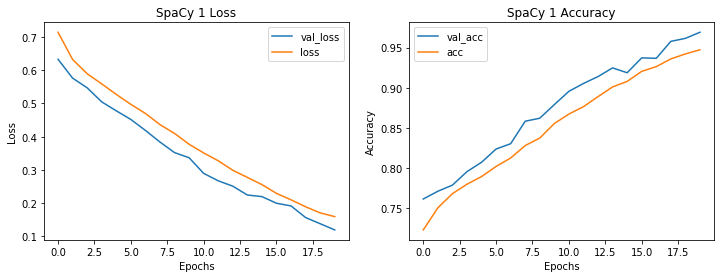

In [98]:
nn_compare_s.plot_val_history()

In [99]:
nn_compare_s.score_comparison

,SpaCy 1 Holdout
Loss,1.433453
Accuracy,0.688123


In [100]:
nn_compare_tf.fit_models()

Epoch 1/20
463/463 [==============================] - 2s 2ms/step - loss: 0.7541 - acc: 0.6864 - val_loss: 0.4508 - val_acc: 0.8331
Epoch 2/20
463/463 [==============================] - 1s 2ms/step - loss: 0.4609 - acc: 0.8169 - val_loss: 0.3327 - val_acc: 0.8920
Epoch 3/20
463/463 [==============================] - 1s 2ms/step - loss: 0.3413 - acc: 0.8747 - val_loss: 0.2319 - val_acc: 0.9266
Epoch 4/20
463/463 [==============================] - 1s 2ms/step - loss: 0.2423 - acc: 0.9201 - val_loss: 0.1436 - val_acc: 0.9680
Epoch 5/20
463/463 [==============================] - 1s 2ms/step - loss: 0.1504 - acc: 0.9585 - val_loss: 0.0798 - val_acc: 0.9837
Epoch 6/20
463/463 [==============================] - 1s 2ms/step - loss: 0.0847 - acc: 0.9827 - val_loss: 0.0408 - val_acc: 0.9951
Epoch 7/20
463/463 [==============================] - 1s 2ms/step - loss: 0.0387 - acc: 0.9956 - val_loss: 0.0208 - val_acc: 0.9971
Epoch 8/20
463/463 [==============================] - 1s 2ms/step - loss: 0.

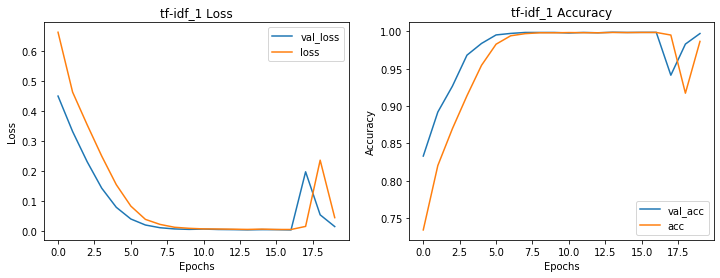

In [101]:
nn_compare_tf.plot_val_history()

In [102]:
nn_compare_tf.score_comparison

,tf-idf_1 Holdout
Loss,1.554602
Accuracy,0.728015


## To Do:
- Improve Accuracy with Stop Words
- Age word clouds
- Popularity Word Clouds
- Quality Word Clouds
- UMAP of each
- Restrict to last 15-20 years
- Random Forest Models
- Multilabel Output
- NYT API - Bestselling author? - Age Group Bias? Genre Bias?
- NYT API - NYT Review? - Same questions

In [88]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [89]:
df_desc

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url,aliens,alternate_history,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel,Num_Genres,genres,Age_Group
0,Obsidian,Obsidian,Jennifer L. Armentrout,English,4.17,236780,18161,Starting over sucks.When we moved to West Virg...,2011,"{'Young Adult': 3439, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/12578077-o...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[Young Adult, Fantasy (Paranormal) , Fantasy, ...",Young Adult
1,Onyx,Onyx,Jennifer L. Armentrout,English,4.27,153429,10497,BEING CONNECTED TO DAEMON BLACK SUCKS… Thanks ...,2012,"{'Young Adult': 2271, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/13047090-onyx,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[Young Adult, Fantasy (Paranormal) , Romance, ...",Young Adult
2,The 5th Wave,The 5th Wave,Rick Yancey,English,4.03,400600,29990,"After the 1st wave, only darkness remains. Aft...",2013,"{'Young Adult': 5436, 'Science Fiction': 3327,...",https://www.goodreads.com/book/show/16101128-t...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,"[Young Adult, Science Fiction, Science Fiction...",Young Adult
3,The Host,The Host,Stephenie Meyer,English,3.84,915026,41673,Melanie Stryder refuses to fade away. The eart...,2008,"{'Young Adult': 4529, 'Science Fiction': 4285,...",https://www.goodreads.com/book/show/1656001.Th...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,"[Young Adult, Science Fiction, Fantasy, Romanc...",Young Adult
4,Opal,Opal,Jennifer L. Armentrout,None,4.27,129006,9463,No one is like Daemon Black.When he set out to...,2012,"{'Young Adult': 1855, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/13362536-opal,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[Young Adult, Fantasy (Paranormal) , Romance, ...",Young Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11090,Always Mine,Always Mine (The Blackthorn Trilogy #1),Sophia Johnson,English,3.55,276,27,The great Lord Damron is no more than a shadow...,2006,"{'Romance (Historical Romance) ': 26, 'Science...",https://www.goodreads.com/book/show/524577.Alw...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[Romance (Historical Romance) , Science Fictio...",Adult
11091,Hour of the Olympics,"Hour of the Olympics (Magic Tree House, #16)",Mary Pope Osborne,English,3.94,8710,284,The #1 bestselling chapter book series of all ...,1998,"{'Fantasy': 115, 'Childrens': 114, 'Fiction': ...",https://www.goodreads.com/book/show/181401.Hou...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[Fantasy, Childrens, Fiction, Historical (Hist...",Children
11092,Tumbling Through Time,Tumbling Through Time,Gwyn Cready,English,3.34,312,51,"In her sparkling and hilarious debut, author G...",2000,"{'Romance': 28, 'Science Fiction (Time Travel)...",https://www.goodreads.com/book/show/1888734.Tu...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[Romance, Science Fiction (Time Travel) , Roma...",Adult
11093,Time's Arrow,Time’s Arrow,Martin Amis,English,3.71,14934,1106,In Time's Arrow the doctor Tod T. Friendly die...,1991,"{'Fiction': 586, 'Historical (Historical Ficti...",https://www.goodreads.com/book/show/23031.Time...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[Fiction, Historical (Historical Fiction) , No...",Adult


In [90]:
import json

def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [91]:
keys = get_keys("/Users/andrew/.secret/nyt_api.json")
api_key = keys['api_key']
secret = keys['secret']

FileNotFoundError: [Errno 2] No such file or directory: '/Users/andrew/.secret/nyt_api.json'

In [ ]:
from pynytimes import NYTAPI

In [ ]:
nyt = NYTAPI(api_key, parse_dates=True)

In [ ]:
reviews = nyt.book_reviews(author='Stephen King')

In [ ]:
len(reviews)

In [ ]:
pd.json_normalize(reviews)

In [113]:
df_desc

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url,aliens,alternate_history,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel,Num_Genres,genres,Age_Group
0,Obsidian,Obsidian,Jennifer L. Armentrout,English,4.17,236780,18161,Starting over sucks.When we moved to West Virg...,2011,"{'Young Adult': 3439, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/12578077-o...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[Young Adult, Fantasy (Paranormal) , Fantasy, ...",Young Adult
1,Onyx,Onyx,Jennifer L. Armentrout,English,4.27,153429,10497,BEING CONNECTED TO DAEMON BLACK SUCKS… Thanks ...,2012,"{'Young Adult': 2271, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/13047090-onyx,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[Young Adult, Fantasy (Paranormal) , Romance, ...",Young Adult
2,The 5th Wave,The 5th Wave,Rick Yancey,English,4.03,400600,29990,"After the 1st wave, only darkness remains. Aft...",2013,"{'Young Adult': 5436, 'Science Fiction': 3327,...",https://www.goodreads.com/book/show/16101128-t...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,"[Young Adult, Science Fiction, Science Fiction...",Young Adult
3,The Host,The Host,Stephenie Meyer,English,3.84,915026,41673,Melanie Stryder refuses to fade away. The eart...,2008,"{'Young Adult': 4529, 'Science Fiction': 4285,...",https://www.goodreads.com/book/show/1656001.Th...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,"[Young Adult, Science Fiction, Fantasy, Romanc...",Young Adult
4,Opal,Opal,Jennifer L. Armentrout,None,4.27,129006,9463,No one is like Daemon Black.When he set out to...,2012,"{'Young Adult': 1855, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/13362536-opal,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[Young Adult, Fantasy (Paranormal) , Romance, ...",Young Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11090,Always Mine,Always Mine (The Blackthorn Trilogy #1),Sophia Johnson,English,3.55,276,27,The great Lord Damron is no more than a shadow...,2006,"{'Romance (Historical Romance) ': 26, 'Science...",https://www.goodreads.com/book/show/524577.Alw...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[Romance (Historical Romance) , Science Fictio...",Adult
11091,Hour of the Olympics,"Hour of the Olympics (Magic Tree House, #16)",Mary Pope Osborne,English,3.94,8710,284,The #1 bestselling chapter book series of all ...,1998,"{'Fantasy': 115, 'Childrens': 114, 'Fiction': ...",https://www.goodreads.com/book/show/181401.Hou...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[Fantasy, Childrens, Fiction, Historical (Hist...",Children
11092,Tumbling Through Time,Tumbling Through Time,Gwyn Cready,English,3.34,312,51,"In her sparkling and hilarious debut, author G...",2000,"{'Romance': 28, 'Science Fiction (Time Travel)...",https://www.goodreads.com/book/show/1888734.Tu...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[Romance, Science Fiction (Time Travel) , Roma...",Adult
11093,Time's Arrow,Time’s Arrow,Martin Amis,English,3.71,14934,1106,In Time's Arrow the doctor Tod T. Friendly die...,1991,"{'Fiction': 586, 'Historical (Historical Ficti...",https://www.goodreads.com/book/show/23031.Time...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[Fiction, Historical (Historical Fiction) , No...",Adult


In [114]:
books = nyt.best_sellers_list()

In [115]:
len(pd.json_normalize(books))

15

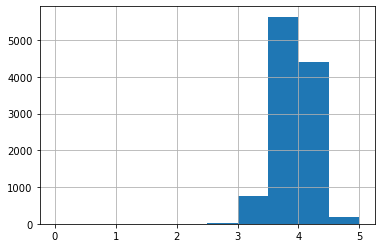

In [116]:
df_desc['Rating_score'].hist()

In [117]:
df_desc['Rating_votes'].describe()

count    1.102500e+04
mean     2.529002e+04
std      1.684630e+05
min      0.000000e+00
25%      6.620000e+02
50%      2.037000e+03
75%      7.387000e+03
max      7.336299e+06
Name: Rating_votes, dtype: float64

In [118]:
def popularity(rating):
    
    if rating <=  6.620000e+02:
        return 'unpopular'
    elif rating <= 7.387000e+03:
        return 'popular'
    else:
        return 'blockbuster'

In [119]:
df_desc['Popularity'] = df_desc['Rating_votes'].map(lambda x: popularity(x))

In [120]:
df_desc['Rating_score'].describe()

count    11025.000000
mean         3.923708
std          0.296662
min          0.000000
25%          3.730000
50%          3.930000
75%          4.130000
max          5.000000
Name: Rating_score, dtype: float64

In [121]:
def quality(score):
    
    if score <= 3.73:
        return "Bad"
    elif score <= 3.93:
        return "Good"
    else:
        return "Excellent"

In [122]:
df_desc['Quality'] = df_desc['Rating_score'].map(lambda x: quality(x))

In [123]:
df_desc[df_desc['Quality'] =='Excellent']['Year_published'].describe()

count    5473.000000
mean     2001.957062
std       112.580534
min         0.000000
25%      2005.000000
50%      2013.000000
75%      2016.000000
max      2021.000000
Name: Year_published, dtype: float64

In [124]:
df_desc[df_desc['Quality'] =='Good']['Year_published'].describe()

count    2779.000000
mean     2002.456279
std        77.742355
min         0.000000
25%      2001.000000
50%      2011.000000
75%      2014.000000
max      2021.000000
Name: Year_published, dtype: float64

In [125]:
df_desc[df_desc['Quality'] =='Bad']['Year_published'].describe()

count    2773.000000
mean     2001.614858
std        94.988833
min         0.000000
25%      2004.000000
50%      2011.000000
75%      2014.000000
max      2021.000000
Name: Year_published, dtype: float64

In [126]:
df_desc[df_desc['Popularity'] =='blockbuster']['Year_published'].describe()

count    2756.000000
mean     2003.314949
std        21.737793
min      1516.000000
25%      2000.000000
50%      2010.000000
75%      2014.000000
max      2020.000000
Name: Year_published, dtype: float64

In [127]:
df_desc[df_desc['Popularity'] =='popular']['Year_published'].describe()

count    5511.000000
mean     2004.563056
std        86.441203
min         0.000000
25%      2006.000000
50%      2012.000000
75%      2015.000000
max      2021.000000
Name: Year_published, dtype: float64

In [128]:
df_desc[df_desc['Popularity'] =='unpopular']['Year_published'].describe()

count    2758.000000
mean     1995.551849
std       157.657696
min         0.000000
25%      2003.000000
50%      2012.000000
75%      2015.000000
max      2021.000000
Name: Year_published, dtype: float64

In [129]:
len(df_desc[(df_desc['Year_published'] >= 2005) & (df_desc['Year_published'] < 2020)])

7861

In [77]:
df_recent = df_desc[(df_desc['Year_published'] >= 2005) & (df_desc['Year_published'] < 2020)]

In [78]:
df_recent['Rating_score'].describe()

count    7861.000000
mean        3.930634
std         0.298958
min         2.500000
25%         3.730000
50%         3.940000
75%         4.140000
max         5.000000
Name: Rating_score, dtype: float64

In [132]:
def quality(score):
    
    if score <= 3.73:
        return "Bad"
    elif score <= 4.14:
        return "Good"
    else:
        return "Excellent"

In [133]:
df_recent['Rating_votes'].describe()

count    7.861000e+03
mean     1.847820e+04
std      1.262010e+05
min      1.000000e+00
25%      6.860000e+02
50%      1.941000e+03
75%      6.326000e+03
max      6.572148e+06
Name: Rating_votes, dtype: float64

In [134]:
def popularity(rating):
    
    if rating <=  6.860000e+02:
        return 'unpopular'
    elif rating <= 6.326000e+03:
        return 'popular'
    else:
        return 'blockbuster'

In [135]:
df_recent['Popularity'] = df_recent['Rating_votes'].map(lambda x: popularity(x))
df_recent['Quality'] = df_recent['Rating_score'].map(lambda x: quality(x))

In [136]:
df_block = df_recent[df_recent['Popularity'] == 'blockbuster']
df_unpop = df_recent[df_recent['Popularity'] == 'unpopular']
df_pop = df_recent[df_recent['Popularity'] == 'popular']

In [137]:
df_block

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url,aliens,alternate_history,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel,Num_Genres,genres,Age_Group,Popularity,Quality
0,Obsidian,Obsidian,Jennifer L. Armentrout,English,4.17,236780,18161,Starting over sucks.When we moved to West Virg...,2011,"{'Young Adult': 3439, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/12578077-o...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[Young Adult, Fantasy (Paranormal) , Fantasy, ...",Young Adult,blockbuster,Excellent
1,Onyx,Onyx,Jennifer L. Armentrout,English,4.27,153429,10497,BEING CONNECTED TO DAEMON BLACK SUCKS… Thanks ...,2012,"{'Young Adult': 2271, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/13047090-onyx,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[Young Adult, Fantasy (Paranormal) , Romance, ...",Young Adult,blockbuster,Excellent
2,The 5th Wave,The 5th Wave,Rick Yancey,English,4.03,400600,29990,"After the 1st wave, only darkness remains. Aft...",2013,"{'Young Adult': 5436, 'Science Fiction': 3327,...",https://www.goodreads.com/book/show/16101128-t...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,"[Young Adult, Science Fiction, Science Fiction...",Young Adult,blockbuster,Good
3,The Host,The Host,Stephenie Meyer,English,3.84,915026,41673,Melanie Stryder refuses to fade away. The eart...,2008,"{'Young Adult': 4529, 'Science Fiction': 4285,...",https://www.goodreads.com/book/show/1656001.Th...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,"[Young Adult, Science Fiction, Fantasy, Romanc...",Young Adult,blockbuster,Good
4,Opal,Opal,Jennifer L. Armentrout,None,4.27,129006,9463,No one is like Daemon Black.When he set out to...,2012,"{'Young Adult': 1855, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/13362536-opal,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[Young Adult, Fantasy (Paranormal) , Romance, ...",Young Adult,blockbuster,Excellent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10959,Ethereal,Ethereal,Addison Moore,English,3.75,13685,954,"Sixteen year-old, Skyla Messenger is a dead gi...",2011,"{'Fantasy (Paranormal) ': 215, 'Young Adult': ...",https://www.goodreads.com/book/show/49420925-e...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[Fantasy (Paranormal) , Young Adult, Paranorma...",Young Adult,blockbuster,Good
10986,The Fire Chronicle,The Fire Chronicle,John Stephens,English,4.23,8110,704,"After the tumultuous events of last winter, Ka...",2012,"{'Fantasy': 443, 'Childrens (Middle Grade) ': ...",https://www.goodreads.com/book/show/13262797-t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[Fantasy, Childrens (Middle Grade) , Adventure...",Children,blockbuster,Excellent
10997,Intertwined,Intertwined,Gena Showalter,English,3.87,18388,1255,There’s something about the new guy at Crossro...,2009,"{'Young Adult': 552, 'Fantasy (Paranormal) ': ...",https://www.goodreads.com/book/show/6344423-in...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[Young Adult, Fantasy (Paranormal) , Fantasy, ...",Young Adult,blockbuster,Good
11060,The Afterlife of Holly Chase,The Afterlife of Holly Chase,Cynthia Hand,English,3.99,12931,3315,"On Christmas Eve five years ago, Holly was vis...",2017,"{'Fantasy': 763, 'Young Adult': 659, 'Holiday ...",https://www.goodreads.com/book/show/33843251-t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"[Fantasy, Young Adult, Holiday (Christmas) , R...",Young Adult,blockbuster,Good


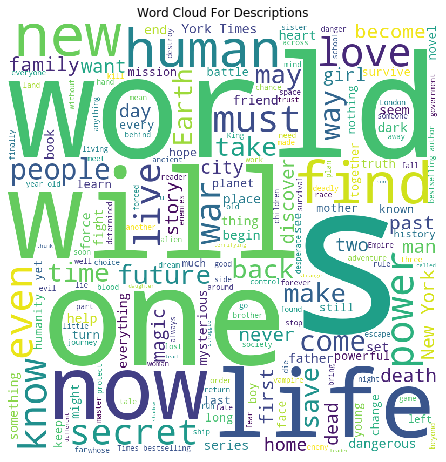

In [138]:
words = ' '.join(list(df_block['Book_Description']))

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(words)

# plot the WordCloud image                       
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title(f'Word Cloud For Descriptions')
plt.show()

In [139]:
def word_cloud(column):

    words = ' '.join(list(column))

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(words)

    # plot the WordCloud image                       
    plt.figure(figsize = (6, 6), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(f'Word Cloud For Descriptions')
    plt.show()

In [ ]:
def freq_dist(column, keep_stopwords = True):

    words = ' '.join(list(column))

    if keep_stopwords == True:
        tokens = words.split(' ')
        
    else:
        tokens = [word.lower() for word in words.split(' ') if word.lower() not in stopwords_list]

    data_freqdist = FreqDist(tokens)

    x = []
    y = []

    for token in data_freqdist.most_common(50):
        x.append(token[0])
        y.append(token[1])

    plt.figure(figsize=(15, 6))
    plt.bar(x=x, height=y)
    plt.xticks(rotation=45)
    plt.xlabel('Words')
    plt.title(f'Most Common Words')
    plt.ylabel('Frequency')
    plt.show()

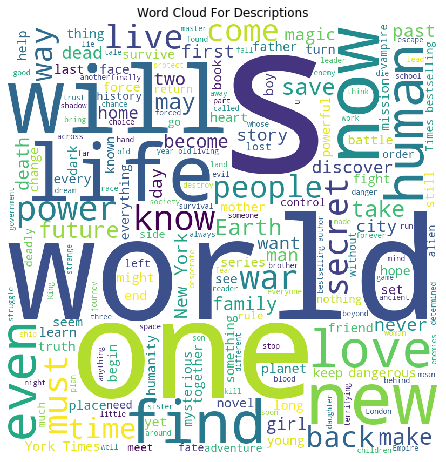

In [141]:
word_cloud(df_block['Book_Description'])

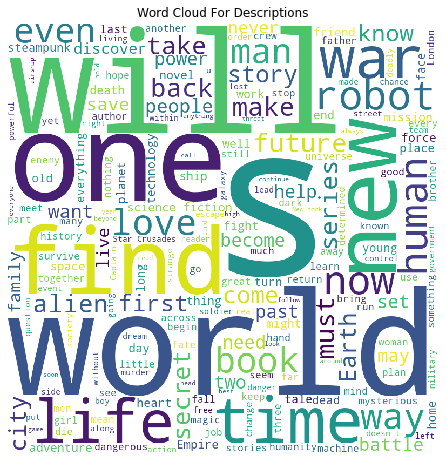

In [142]:
word_cloud(df_unpop['Book_Description'])

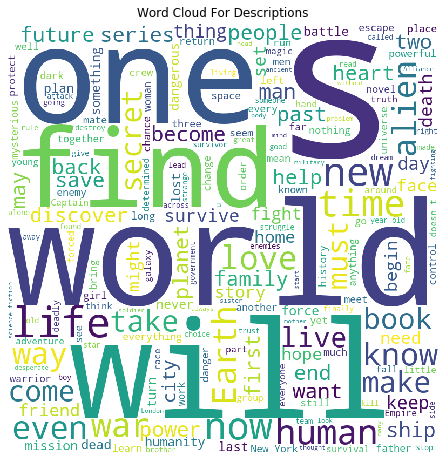

In [143]:
word_cloud(df_pop['Book_Description'])

In [144]:
df_bad = df_recent[df_recent['Quality'] == 'Bad']
df_good = df_recent[df_recent['Quality'] == 'Good']
df_best = df_recent[df_recent['Quality'] == 'Excellent']

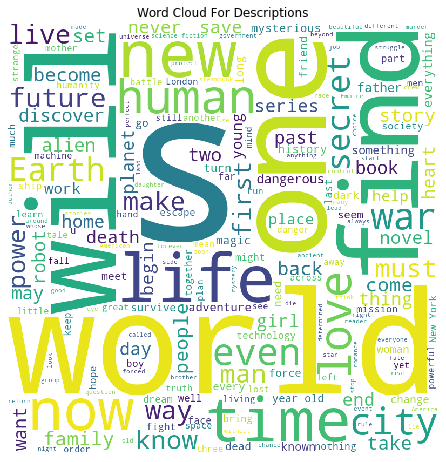

In [145]:
word_cloud(df_bad['Book_Description'])

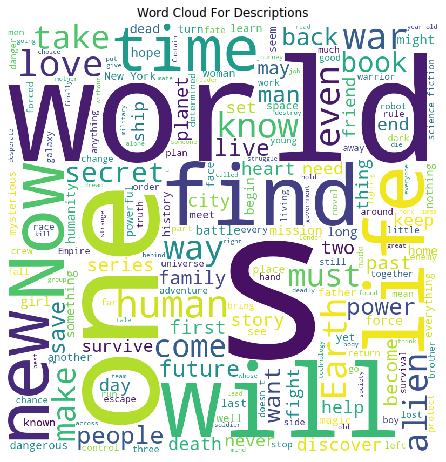

In [146]:
word_cloud(df_good['Book_Description'])

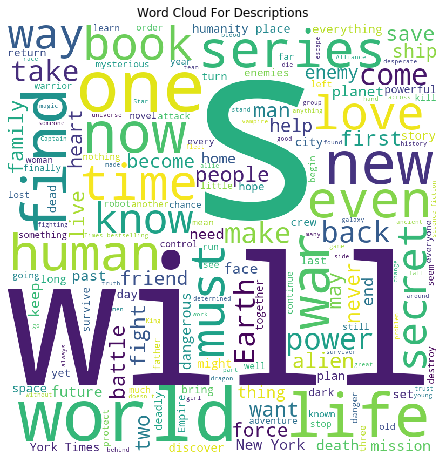

In [147]:
word_cloud(df_best['Book_Description'])

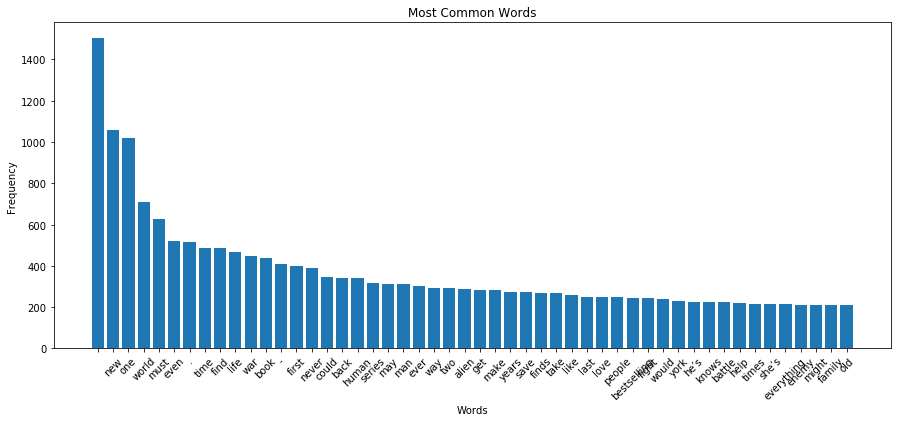

In [148]:
freq_dist(df_best['Book_Description'], keep_stopwords=False)

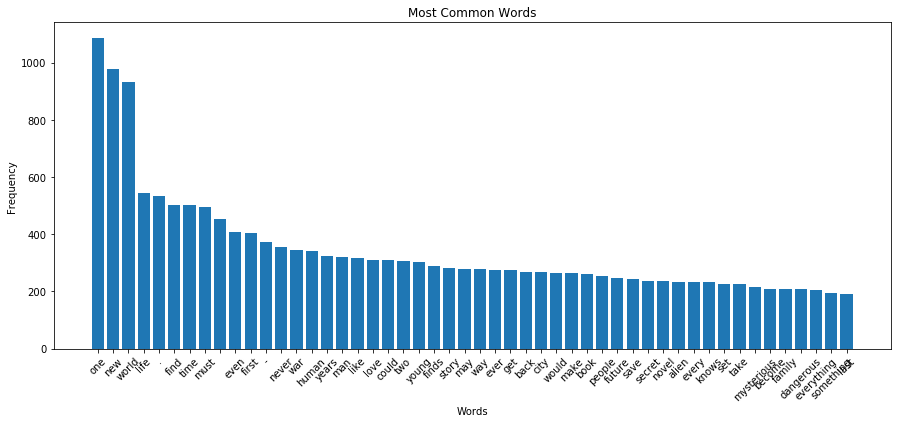

In [149]:
freq_dist(df_bad['Book_Description'], keep_stopwords=False)

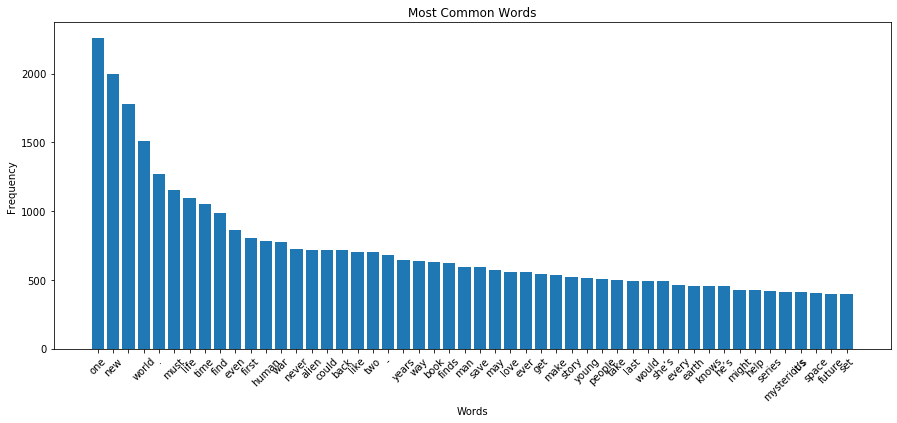

In [150]:
freq_dist(df_good['Book_Description'], keep_stopwords=False)

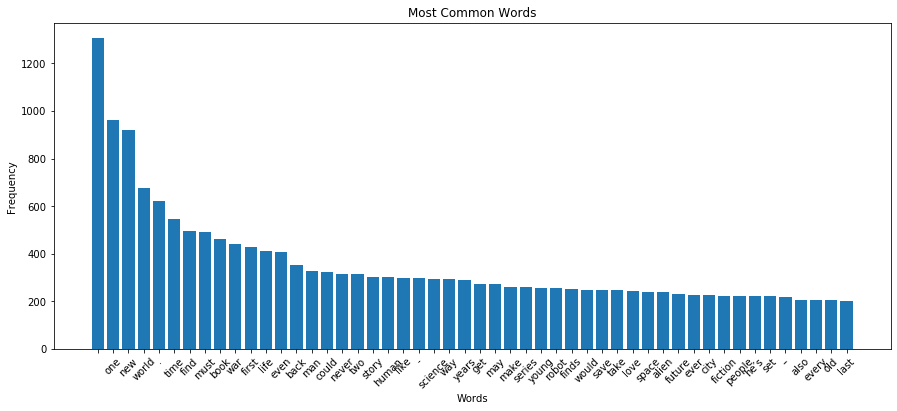

In [151]:
freq_dist(df_unpop['Book_Description'], keep_stopwords=False)

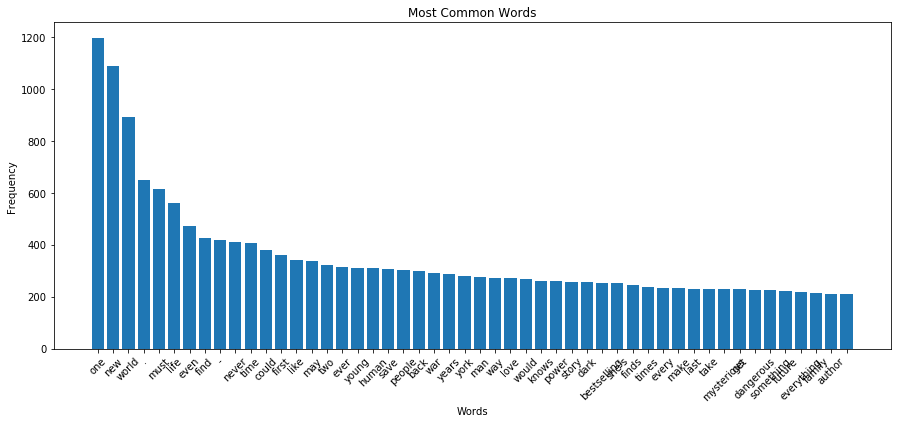

In [152]:
freq_dist(df_block['Book_Description'], keep_stopwords=False)

In [153]:
df_recent['Age_Group'].value_counts(normalize=True)

Adult          0.689607
Young Adult    0.250477
Children       0.059916
Name: Age_Group, dtype: float64

In [154]:
df_children = df_recent[df_recent['Age_Group'] == 'Children']
df_YA = df_recent[df_recent['Age_Group'] == 'Young Adult']
df_adult = df_recent[df_recent['Age_Group'] == 'Adult']

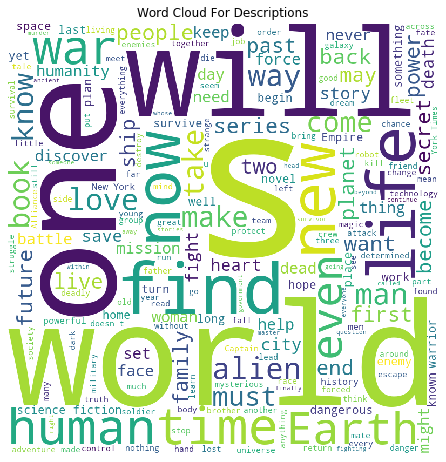

In [155]:
word_cloud(df_adult['Book_Description'])

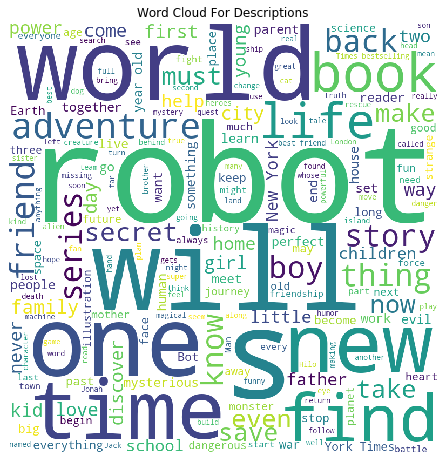

In [156]:
word_cloud(df_children['Book_Description'])

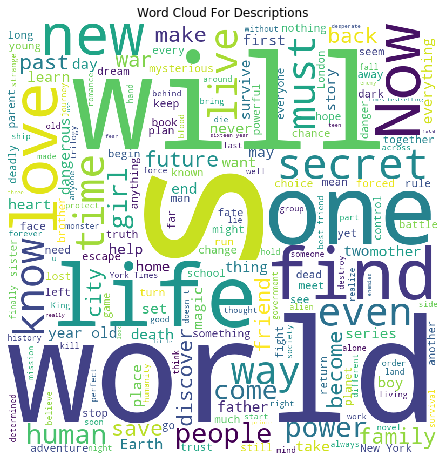

In [157]:
word_cloud(df_YA['Book_Description'])

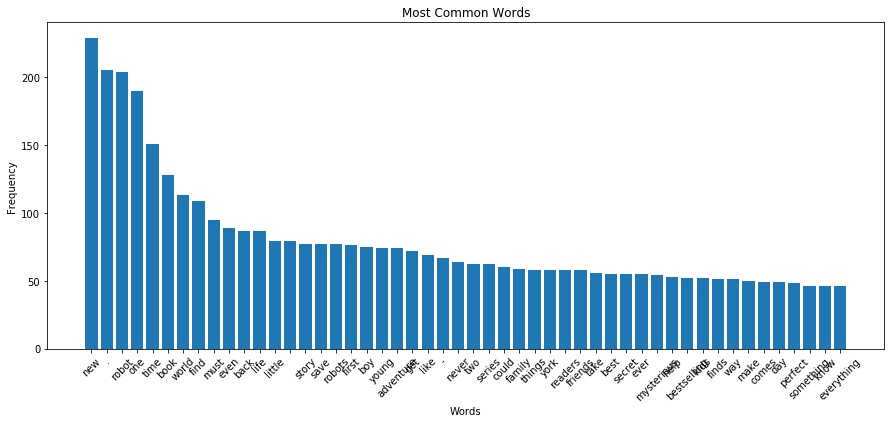

In [158]:
freq_dist(df_children['Book_Description'],keep_stopwords=False)

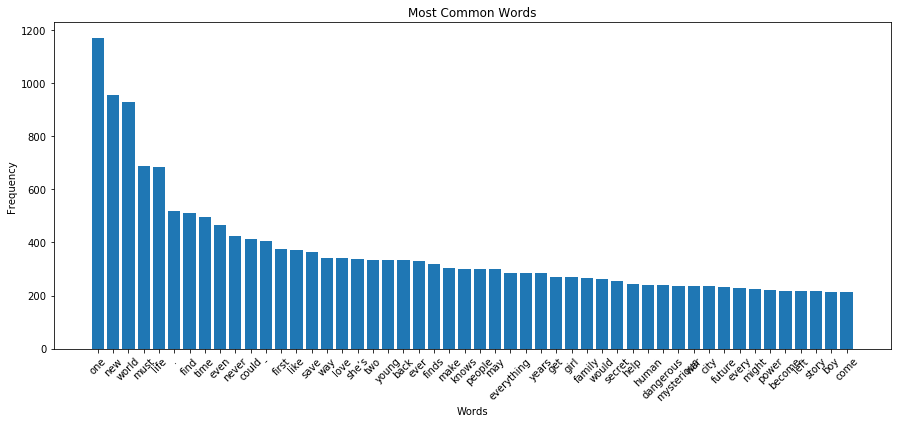

In [159]:
freq_dist(df_YA['Book_Description'],keep_stopwords=False)

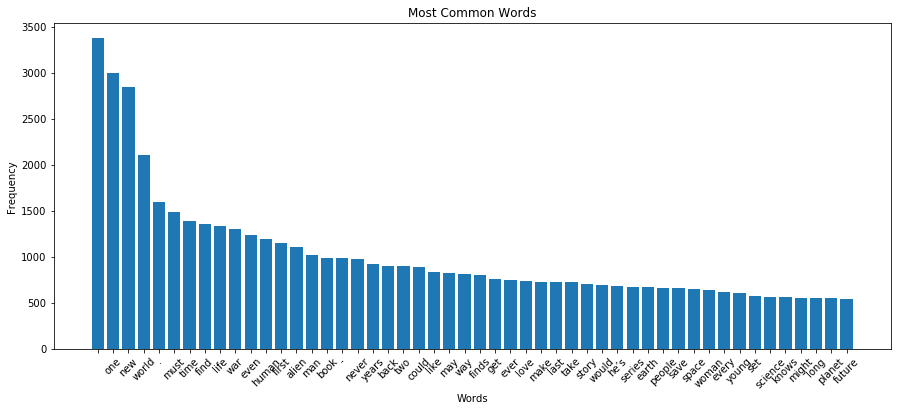

In [160]:
freq_dist(df_adult['Book_Description'],keep_stopwords=False)

In [161]:
# spacy_qual = TextSet(df_recent['Book_Description'], 
#                      df_recent['Quality'], 
#                      name='SpaCy', 
#                      is_spacy=True)

In [162]:
# tf_qual_300 = TextSet(df_recent['Book_Description'], 
#                      df_recent['Quality'], 
#                      name='TF_300', 
#                      is_spacy=False, keep_stopwords = False)

In [163]:
# tf_qual_400 = TextSet(df_recent['Book_Description'], 
#                      df_recent['Quality'], 
#                      name='TF_400', 
#                      is_spacy=False, keep_stopwords = False)

In [164]:
# tf_qual_3 = TextSet(df_recent['Book_Description'], 
#                      df_recent['Quality'], 
#                      name='TF_3', 
#                      is_spacy=False, keep_stopwords = False)

In [166]:
# spacy_qual.vectorize()
# tf_qual_300.vectorize(max_features=300)
# tf_qual_400.vectorize(max_features=None)
# tf_qual_3.vectorize(ngram_range=(1,3))

In [167]:
# data_q = [spacy_qual, tf_qual_300, tf_qual_400, tf_qual_3]

In [168]:
# svm_pipe_q = Pipeline([('scaler', StandardScaler()), ('rbf',svm.SVC())])

# grid_q = {
#     'rbf__kernel':['rbf'],
#     'rbf__gamma' :['scale','auto'],
#     'rbf__C': [1, 1e12],
#     'rbf__decision_function_shape': ['ovo','ovr']
# }

# svm_grid_q = GridSearchCV(svm_pipe_q, param_grid=grid_q, scoring='accuracy',cv=5)
# svm_compare_q = ModelComparison(pipeline=svm_pipe_q, data_list=data_q, y_format='label',name='svm_q')

In [169]:
# svm_compare_q.fit_models()
# svm_compare_q.score_comparison

In [170]:
# svm_compare_q.calc_scores(data_type='holdout')
# svm_compare_q.score_comparison

In [171]:
# svm_compare_q.all_scores

In [172]:
# tf_qual_h = TextSet(df_recent['Book_Description'], 
#                      df_recent['Quality'], 
#                      name='TF_h', 
#                      is_spacy=False, keep_stopwords = False)

In [173]:
# tf_qual_h.vectorize(max_features=400, ngram_range=(1,3))

In [174]:
# svm_compare_q = ModelComparison(pipeline=svm_pipe_q, data_list=[tf_qual_h], y_format='label',name='svm_q_h')

In [175]:
# svm_compare_q.fit_models()
# svm_compare_q.score_comparison

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [177]:
# rf_pipe_q = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

# grid_q = {
#     'rf__n_estimators':[50, 100],
#     'rf__criterion' :['gini','entropy'],
#     'rf__max_depth': [5, 10, 15],
# }

# rf_grid_q = GridSearchCV(rf_pipe_q, param_grid=grid_q, scoring='accuracy',cv=5)
# rf_compare_q = ModelComparison(pipeline=rf_grid_q, data_list=data_q, y_format='label',name='rf_q')

In [178]:
# rf_compare_q.fit_models()
# rf_compare_q.score_comparison

## Popularity

In [179]:
# spacy_pop = TextSet(df_recent['Book_Description'], 
#                      df_recent['Popularity'], 
#                      name='SpaCy', 
#                      is_spacy=True)

In [180]:
# tf_pop_300 = TextSet(df_recent['Book_Description'], 
#                      df_recent['Popularity'], 
#                      name='TF_300', 
#                      is_spacy=False, keep_stopwords = False)

In [181]:
# tf_pop_none = TextSet(df_recent['Book_Description'], 
#                      df_recent['Popularity'], 
#                      name='TF_None', 
#                      is_spacy=False, keep_stopwords = False)

In [182]:
# spacy_pop.vectorize()
# tf_pop_300.vectorize(max_features=300)
# tf_pop_none.vectorize(max_features=None)

In [183]:
# data_p = [spacy_pop, tf_pop_300, tf_pop_none]

In [184]:
# svm_pipe_p = Pipeline([('scaler', StandardScaler()), ('rbf',svm.SVC())])

# grid_p = {
#     'rbf__kernel':['rbf'],
#     'rbf__gamma' :['scale','auto'],
#     'rbf__C': [1, 1e12],
#     'rbf__decision_function_shape': ['ovo','ovr']
# }

# svm_grid_p = GridSearchCV(svm_pipe_p, param_grid=grid_p, scoring='accuracy',cv=5)
# svm_compare_p = ModelComparison(pipeline=svm_pipe_p, data_list=data_p, y_format='label',name='svm_p')

In [185]:
# svm_compare_q.fit_models()
# svm_compare_q.score_comparison

In [186]:
# rf_pipe_p = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

# grid_p = {
#     'rf__n_estimators':[50, 100],
#     'rf__criterion' :['gini','entropy'],
#     'rf__max_depth': [5, 10, 15],
# }

# rf_grid_p = GridSearchCV(rf_pipe_p, param_grid=grid_p, scoring='accuracy',cv=5)
# rf_compare_p = ModelComparison(pipeline=rf_grid_p, data_list=data_p, y_format='label',name='rf_p')

In [187]:
# rf_compare_q.fit_models()
# rf_compare_q.score_comparison

## Next Steps

- UMAP analysis - pre-2000 vs. post 2000
- Freqdist analysis - same dates
- Add in bestseller/nyt review info - see if that improves accuracy
- Quality vs. Popularity
- Genre Predictions pre-2000 vs. post 2000

In [92]:
len(df_desc[df_desc['Year_published'] <= 2000])

2185

In [93]:
len(df_desc[df_desc['Year_published'] > 2000])

8840

In [43]:
df_old = df_desc[df_desc['Year_published'] <= 2000]
df_new = df_desc[df_desc['Year_published'] >= 2000]

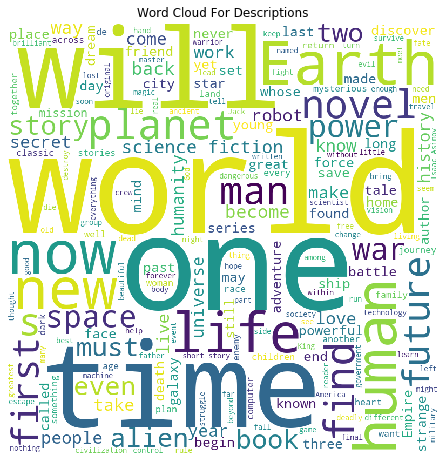

In [191]:
word_cloud(df_old['Book_Description'])

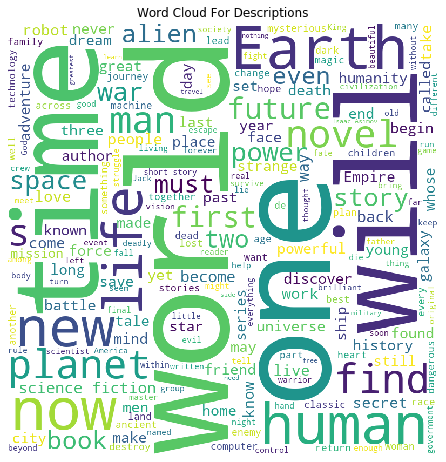

In [192]:
word_cloud(df_new['Book_Description'])

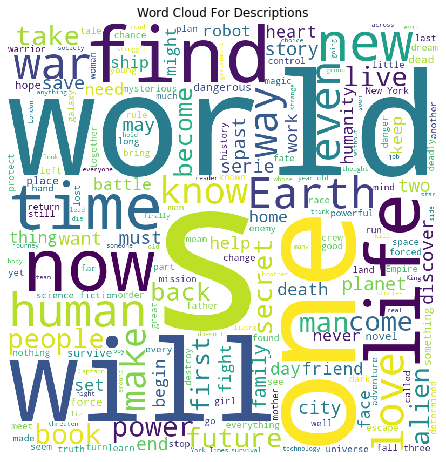

In [193]:
word_cloud(df_desc['Book_Description'])

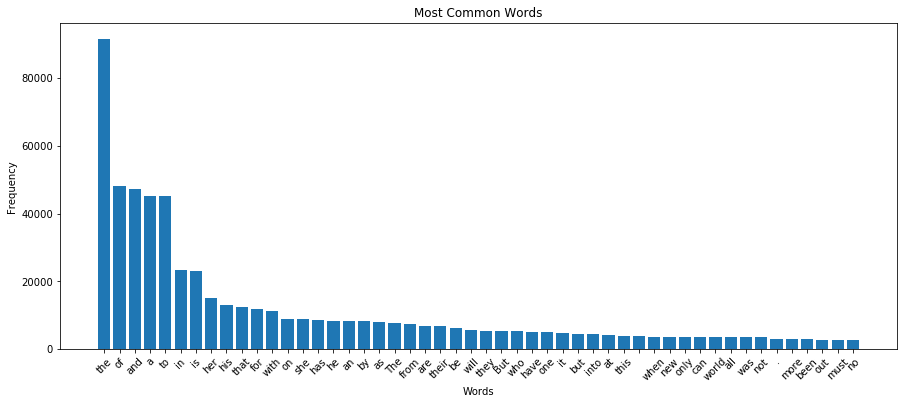

In [194]:
freq_dist(df_desc['Book_Description'])

In [195]:
# tf_qual_400.word_cloud()

NameError: name 'tf_qual_400' is not defined

In [ ]:
# tf_qual_400.plot_frequency()

In [95]:
extra_stopwords = [
    "'s",
    'one',
    'world',
    'new',
    'life',
    'time',
    'must',
    "n't",
    'find',
    'even',
    'first',
    'human',
    'earth',
    'love',
    'book',
    'back']

In [96]:
stopwords_list.extend(extra_stopwords)

In [45]:
tf_idf_400_2 = TextSet(X=df_new['Book_Description'],
                 y=df_new['Age_Group'],
                 name='tf-idf_400_2',
                 is_spacy=False, 
                 keep_stopwords=False)

--- 230.69521713256836 seconds ---


In [46]:
tf_idf_None = TextSet(X=df_new['Book_Description'],
                 y=df_new['Age_Group'],
                 name='tf-idf_None',
                 is_spacy=False, 
                 keep_stopwords=False)

--- 227.8207471370697 seconds ---


In [47]:
tf_idf_400_1 = TextSet(X=df_new['Book_Description'],
                 y=df_new['Age_Group'],
                 name='tf-idf_400_1',
                 is_spacy=False, 
                 keep_stopwords=False)

--- 222.0590317249298 seconds ---


In [48]:
tf_idf_400_2.vectorize(max_features=400, ngram_range=(1,2))
tf_idf_None.vectorize(max_features=None)
tf_idf_400_1.vectorize(max_features=400)

In [49]:
data_stop = [tf_idf_400_2, tf_idf_None, tf_idf_400_1]

In [52]:
svm_pipe_stop = Pipeline([('scaler', StandardScaler()), ('rbf',svm.SVC())])

grid= {
    'rbf__kernel':['rbf'],
    'rbf__gamma' :['scale','auto'],
    'rbf__C': [1, 1e12],
    'rbf__decision_function_shape': ['ovo','ovr']
}

svm_grid_stop = GridSearchCV(svm_pipe_stop, param_grid=grid, scoring='accuracy',cv=5)
svm_compare_stop = ModelComparison(pipeline=svm_grid_stop, data_list=data_stop, y_format='label',name='svm')

In [ ]:
svm_compare_stop.fit_models()
svm_compare_stop.score_comparison

In [ ]:
svm_compare_stop.calc_scores(data_type='holdout')
svm_compare_stop.score_comparison

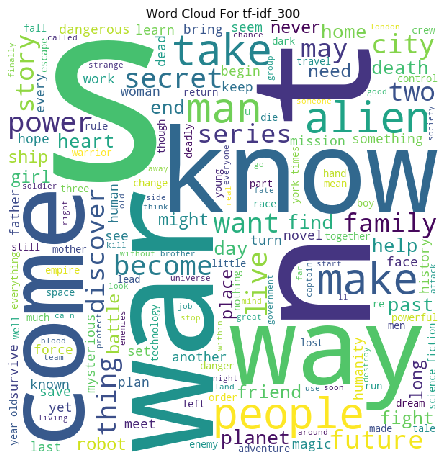

In [205]:
# tf_idf_300.word_cloud()

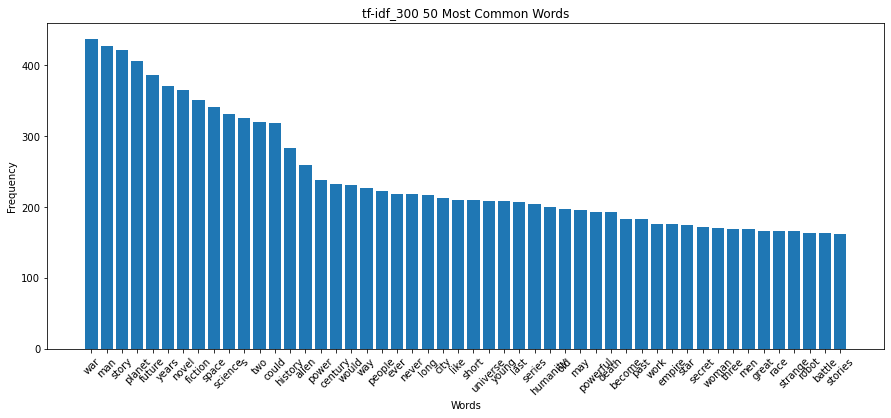

In [106]:
tf_idf_300.plot_frequency()

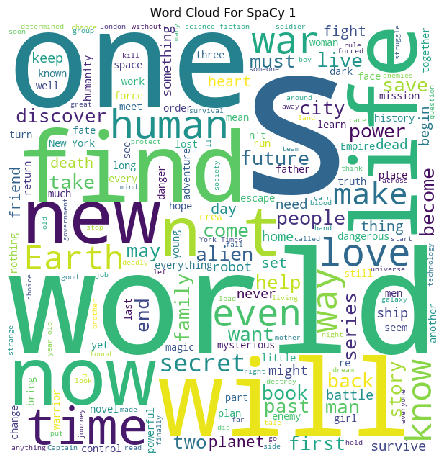

In [207]:
# spacy_1.word_cloud()

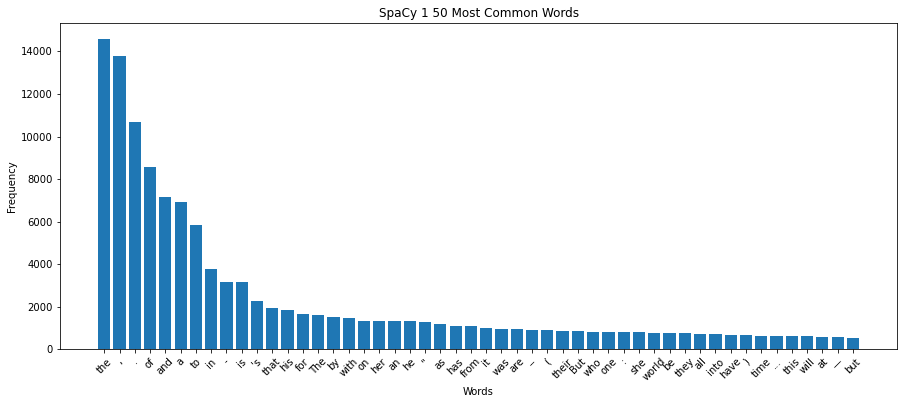

In [107]:
spacy_1.plot_frequency()

In [108]:
rf_pipe_stop = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

grid_stop = {
    'rf__n_estimators':[50, 100],
    'rf__criterion' :['gini','entropy'],
    'rf__max_depth': [5, 10, 15],
}

rf_grid_stop = GridSearchCV(rf_pipe_stop, param_grid=grid_stop, scoring='accuracy',cv=5)
rf_compare_stop = ModelComparison(pipeline=rf_grid_stop, data_list=data_stop, y_format='label',name='rf_stop')

In [109]:
rf_compare_stop.fit_models()
rf_compare_stop.score_comparison

--- 92.62626028060913 seconds to process ---


,SpaCy 1 Test,tf-idf_300 Test,tf-idf_400 Test
Accuracy,0.869492,0.866102,0.861017
Precision (Macro),0.581472,0.621729,0.620260
Recall (Macro),0.370310,0.354839,0.338710
F1 (Macro),0.376431,0.349645,0.318976


In [110]:
df_new['Age_Group'].value_counts(normalize=True)

Adult          0.841190
Children       0.107094
Young Adult    0.051716
Name: Age_Group, dtype: float64

In [125]:
rf_compare_stop.calc_scores(data_type='holdout')
rf_compare_stop.score_comparison

,SpaCy 1 Holdout,tf-idf_300 Holdout,tf-idf_400 Holdout
Accuracy,0.808219,0.794521,0.794521
Precision (Macro),0.519767,0.264840,0.264840
Recall (Macro),0.371795,0.333333,0.333333
F1 (Macro),0.364867,0.295165,0.295165


## Multi-Label Sub-Genre Classifier

- Random Forest Baseline
- GridSearch CSV
- Recent vs. All Time
- Partition into age genres

Need to modify the main class to allow for a OHE raw input

In [80]:
df_y_new = df_new[['aliens','alternate_history','alternate_universe','apocalyptic','cyberpunk','dystopia','hard','military','robots','space_opera','steampunk','time_travel']]

In [81]:
spacy_multi = TextSet(df_new['Book_Description'], 
                     df_y_new, 
                     name='SpaCy', multi_label=True,
                     is_spacy=True)

KeyboardInterrupt: 

In [ ]:
tf_idf_300 = TextSet(X=df_new['Book_Description'],
                 y=df_y_new,
                 name='tf-idf_300',
                 is_spacy=False, multi_label=True,
                 keep_stopwords=False)

In [ ]:
tf_idf_400 = TextSet(X=df_new['Book_Description'],
                 y=df_y_new,
                 name='tf-idf_400',
                 is_spacy=False, multi_label=True,
                 keep_stopwords=False)

In [ ]:
spacy_multi.vectorize()
tf_idf_300.vectorize()
tf_idf_400.vectorize()

In [ ]:
data_genre = [spacy_multi,tf_idf_300,tf_idf_400]

In [122]:
rf_compare_genre = ModelComparison(pipeline=rf_grid_stop, data_list=data_genre, y_format='multi_label',name='rf_genre')

In [123]:
rf_compare_genre.fit_models()
rf_compare_genre.score_comparison

--- 109.84738993644714 seconds to process ---


,SpaCy Test,tf-idf_300 Test,tf-idf_400 Test
Accuracy,0.011864,0.032203,0.027119
Precision (Macro),0.305556,0.521822,0.454756
Recall (Macro),0.006875,0.039399,0.029466
F1 (Macro),0.013373,0.069472,0.052610


In [134]:
rf_pipe_genre_2 = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

grid_genre_2 = {
    'rf__n_estimators': [100, 200, 250],
    'rf__criterion' : ['gini','entropy'],
    'rf__max_depth': [25, 30, 50],
    'rf__min_samples_split': [2, 4, 5],
    'rf__min_samples_leaf': [2, 3, 4]
}

rf_grid_genre_2 = GridSearchCV(rf_pipe_genre_2, param_grid=grid_genre_2, scoring='average_precision',cv=5)
rf_compare_genre_2 = ModelComparison(pipeline=rf_grid_genre_2, data_list=data_genre, y_format='multi_label',name='rf_genre_2')

In [135]:
rf_compare_genre_2.fit_models()
rf_compare_genre_2.score_comparison

--- 4089.651209831238 seconds to process ---


,SpaCy Test,tf-idf_300 Test,tf-idf_400 Test
Accuracy,0.001695,0.066102,0.074576
Precision (Macro),0.083333,0.513492,0.517262
Recall (Macro),0.000595,0.059775,0.065900
F1 (Macro),0.001182,0.101719,0.111895


In [136]:
rf_compare_genre_2.calc_scores(data_type='holdout')
rf_compare_genre_2.score_comparison

,SpaCy Holdout,tf-idf_300 Holdout,tf-idf_400 Holdout
Accuracy,0.009132,0.068493,0.050228
Precision (Macro),0.125000,0.410714,0.400132
Recall (Macro),0.005656,0.055187,0.040199
F1 (Macro),0.010802,0.093493,0.069187


In [137]:
rf_compare_genre_2.pipeline.best_params_

{'rf__criterion': 'gini',
 'rf__max_depth': 50,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 200}

## TO DO

### MVP - JULY 8TH
- Determine ideal Preprocessing for text - stop words vs. spacy vs. tf-idf
- Add in Mutli-Label metrics in class model
- Set final Age Group Model
- Tune multi-label algorithm
- Build stacked algorithm
- Top 5 most similar books - KNN, K Means Clustering - Unsupervised
- Practice on movie descriptions - IMDB?
- Deploy to Streamlit

### Extra - JULY 23RD
- Include NYT Bestselling Data to predict popularity
- Visualizations on most popular books, NYT books, NYT bestsellers (for final notebook/blog posts and streamlit site)
- Webscrape Wikipedia for debut novel descriptions. Create production pipeline to improve dataset

In [138]:
stopwords_list = stopwords.words('english') + [' ', '  ', '   ', 'w/', 's', '’s','n’t']

In [139]:
def process_text(text, is_spacy=False, keep_stopwords=True):
    
    '''
    Processes, cleans, and tokenizes text with multiple options on how to do so. Returns either a SpaCy doc object or a list of tokens
    
    Parameters
    ----------
    text - (str) - the text to be processed
    is_spacy - (bool) - whether or not the return is a SpaCy doc with stop words included. If True is passed, keep_stopwords will be ignored
    keep_stopwords - (bool) - whether or not to remove stopwords using the nltk stopwords library
    keep_links - (bool) - whether or not to turn a handle and website link into a blank word such as WEBSITE for the purposes of sentence structure vectorization
    keep_hashtags - (bool) - whether or not to simply remove the # symbol from a hashtag or remove the hashtag completely
    
    Returns
    -------
    Processed text - doc, if OR list
    
    '''
    doc = nlp(text) # Turns the resulting string into a SpaCy doc object
    
    if is_spacy == True:
        return doc
    
#     text = text.replace("'", '') # Removes apostrophes
    
    if keep_stopwords == False: # Makes all tokens lower case, removes punctuation and stopwords
        return [x.lower() for x in list([token.text for token in doc if token.is_punct == False and token.text.lower() not in stopwords_list])]
    else: # Does the same thing, but keeps stopwords in
        return [x.lower() for x in list([token.text for token in doc if token.is_punct == False])]

In [82]:
spacy_mstop = TextSet(df_new['Book_Description'], 
                     df_y_new, 
                     name='SpaCy_mstop', multi_label=True,
                     is_spacy=True)

--- 249.3626139163971 seconds ---


In [83]:
tf_300_mstop = TextSet(X=df_new['Book_Description'],
                 y=df_y_new,
                 name='tf_300_mstop',
                 is_spacy=False, multi_label=True,
                 keep_stopwords=False)

--- 244.452406167984 seconds ---


In [84]:
tf_400_mstop = TextSet(X=df_new['Book_Description'],
                 y=df_y_new,
                 name='tf_400_mstop',
                 is_spacy=False, multi_label=True,
                 keep_stopwords=False)

--- 242.57626295089722 seconds ---


In [85]:
count_mstop = TextSet(X=df_new['Book_Description'],
                 y=df_y_new,
                 name='count_mstop',
                 is_spacy=False, multi_label=True,
                 keep_stopwords=False)

--- 258.9034540653229 seconds ---


In [86]:
spacy_mstop.vectorize()
tf_300_mstop.vectorize(max_features=300)
tf_400_mstop.vectorize(max_features=400)
count_mstop.vectorize(method='count')

In [145]:
data_genre_2 = data_genre.extend([spacy_mstop,tf_300_mstop,tf_400_mstop,count_mstop])

In [87]:
data_mstop = [spacy_mstop, tf_300_mstop, tf_400_mstop, count_mstop]

In [149]:
rf_pipe_genre_3 = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

grid_genre_3 = {
    'rf__n_estimators': [100, 200],
    'rf__criterion' : ['gini','entropy'],
    'rf__max_depth': [25, 50],
    'rf__min_samples_split': [2, 4],
    'rf__min_samples_leaf': [2, 3]
}

rf_grid_genre_3 = GridSearchCV(rf_pipe_genre_3, param_grid=grid_genre_3, scoring='f1_samples',cv=5)
rf_compare_genre_3 = ModelComparison(pipeline=rf_grid_genre_3, data_list=data_genre, y_format='multi_label',name='rf_genre_3')

In [150]:
rf_compare_genre_3.fit_models()
rf_compare_genre_3.score_comparison

--- 1435.127262353897 seconds to process ---


,SpaCy Test,tf-idf_300 Test,tf-idf_400 Test,SpaCy_mstop Test,tf_300_mstop Test,tf_400_mstop Test,count_mstop Test
Accuracy,0.006780,0.062712,0.072881,0.006780,0.084746,0.081356,0.071186
Precision (Macro),0.250000,0.505638,0.512656,0.250000,0.510949,0.524514,0.523635
Recall (Macro),0.003627,0.057337,0.066178,0.003627,0.070721,0.069613,0.062543
F1 (Macro),0.007138,0.097910,0.111138,0.007138,0.118543,0.117344,0.106484


In [151]:
rf_compare_genre_3.calc_scores(data_type='holdout')
rf_compare_genre_3.score_comparison

,SpaCy Holdout,tf-idf_300 Holdout,tf-idf_400 Holdout,SpaCy_mstop Holdout,tf_300_mstop Holdout,tf_400_mstop Holdout,count_mstop Holdout
Accuracy,0.009132,0.068493,0.059361,0.009132,0.109589,0.105023,0.082192
Precision (Macro),0.125000,0.413194,0.415873,0.166667,0.434524,0.420536,0.394345
Recall (Macro),0.005656,0.056184,0.047960,0.005656,0.079845,0.081343,0.061137
F1 (Macro),0.010802,0.094519,0.083101,0.010935,0.125972,0.128183,0.098053


In [88]:
data_genre_3 = [spacy_mstop, tf_300_mstop, tf_400_mstop, count_mstop]

In [93]:

rf_pipe_genre_4 = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

grid_genre_4 = {
    'rf__n_estimators': [100, 200],
    'rf__criterion' : ['gini','entropy'],
    'rf__max_depth': [25, 50, 75],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [2, 5]
}

rf_grid_genre_4 = GridSearchCV(rf_pipe_genre_4, param_grid=grid_genre_4, scoring='f1_samples',cv=5)
rf_compare_genre_4 = ModelComparison(pipeline=rf_grid_genre_4, data_list=data_genre_3, y_format='multi_label',name='rf_genre_4')

In [131]:
rf_compare_genre_4.fit_models()
rf_compare_genre_4.score_comparison

--- 5293.52516412735 seconds to process ---


,SpaCy_mstop Test,tf_300_mstop Test,tf_400_mstop Test,count_mstop Test
Accuracy,0.012768,0.140445,0.161038,0.121499
Precision (Macro),0.237654,0.752205,0.789962,0.757093
Precision (Micro),0.888889,0.916667,0.929435,0.932065
Recall (Macro),0.009282,0.116972,0.134439,0.101718
Recall (Micro),0.009991,0.123634,0.143928,0.107087
F1 (Micro),0.019759,0.217882,0.249257,0.192103
F1 (Macro),0.017426,0.185450,0.209367,0.163832
F1 (Samples),0.013042,0.153956,0.178646,0.133767


In [132]:
rf_compare_genre_4.calc_scores(data_type='holdout')
rf_compare_genre_4.score_comparison

,SpaCy_mstop Holdout,tf_300_mstop Holdout,tf_400_mstop Holdout,count_mstop Holdout
Accuracy,0.008889,0.146667,0.178889,0.133333
Precision (Macro),0.066667,0.790711,0.723312,0.790716
Precision (Micro),0.800000,0.945122,0.963158,0.952703
Recall (Macro),0.005952,0.125313,0.146905,0.114717
Recall (Micro),0.006849,0.132705,0.156678,0.120719
F1 (Micro),0.013582,0.232733,0.269514,0.214286
F1 (Macro),0.010929,0.195630,0.225160,0.182101
F1 (Samples),0.008889,0.161741,0.193222,0.146926


In [133]:
rf_compare_genre_4.all_scores

,SpaCy_mstop Train,SpaCy_mstop Holdout,tf_300_mstop Train,tf_300_mstop Holdout,tf_400_mstop Train,tf_400_mstop Holdout,count_mstop Train,count_mstop Holdout
Accuracy,0.690094,0.008889,0.464771,0.146667,0.423274,0.178889,0.362352,0.133333
Precision (Macro),1.000000,0.066667,0.998906,0.790711,0.998773,0.723312,0.996818,0.790716
Precision (Micro),1.000000,0.800000,0.999159,0.945122,0.998774,0.963158,0.997104,0.952703
Recall (Macro),0.665513,0.005952,0.455915,0.125313,0.418008,0.146905,0.351709,0.114717
Recall (Micro),0.679089,0.006849,0.469318,0.132705,0.429023,0.156678,0.362655,0.120719
F1 (Micro),0.808878,0.013582,0.638652,0.232733,0.600221,0.269514,0.531866,0.214286
F1 (Macro),0.792651,0.010929,0.601594,0.195630,0.561318,0.225160,0.491070,0.182101
F1 (Samples),0.754273,0.008889,0.527926,0.161741,0.480781,0.193222,0.413521,0.146926


In [95]:
df_new.columns

Index(['Book_Title', 'Original_Book_Title', 'Author_Name', 'Edition_Language',
       'Rating_score', 'Rating_votes', 'Review_number', 'Book_Description',
       'Year_published', 'Genres', 'url', 'aliens', 'alternate_history',
       'alternate_universe', 'apocalyptic', 'cyberpunk', 'dystopia', 'hard',
       'military', 'robots', 'space_opera', 'steampunk', 'time_travel',
       'Num_Genres', 'genres', 'Age_Group'],
      dtype='object')

In [99]:
df_y_new.sum().index

Index(['aliens', 'alternate_history', 'alternate_universe', 'apocalyptic',
       'cyberpunk', 'dystopia', 'hard', 'military', 'robots', 'space_opera',
       'steampunk', 'time_travel'],
      dtype='object')

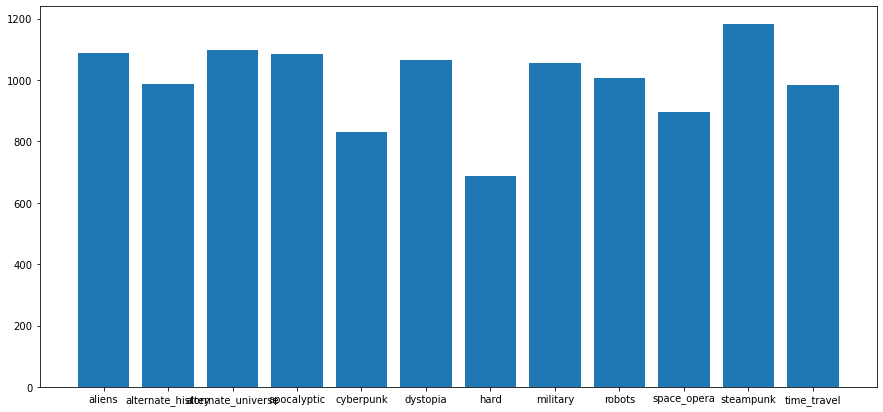

In [101]:
plt.figure(figsize=(15,7))
X = df_y_new.sum().index
y = df_y_new.sum()
plt.bar(x=X, height=y)
plt.show()

In [106]:
genre_dict = {}

def generate_genre_dict(x):
    
    for genre in x:
        if genre in genre_dict.keys():
            genre_dict[genre] += 1
        else:
            genre_dict[genre] = 0

In [107]:
df_desc['genres'].map(lambda x: generate_genre_dict(x))

0        None
1        None
2        None
3        None
4        None
         ... 
11090    None
11091    None
11092    None
11093    None
11094    None
Name: genres, Length: 11025, dtype: object

In [114]:
genre_dict = dict(sorted(genre_dict.items(), key=lambda item: item[1],reverse=True))

In [ ]:
['Fantasy',
 'Romance',
 'Adventure', 
 'Dystopia',
 'Paranormal',
 'Space Opera',
 'Aliens',
 'Historical',
 'Time Travel',
 'Speculative',
 'Apocalyptic',
 'War',
 'Mystery',
 'Steampunk',
 'Magic',
 'Horror',
 'Alternate History',
 'Urban',
 'Cyberpunk',
 'Thriller',
 'Action',
 'Humor',
 'LGBT',
 'Robots',
 'Futuristic',
 'Humor',
 
 

In [ ]:
['Young Adult','Adult','Childrens']

In [121]:
genre_dict['GLBT (Queer) ']

209

In [ ]:
import data_utils as ut
df = pd.DataFrame.from_dict(genre_dict.items())
ut.update_sheet(df,'Project Key')

In [115]:
plt.figure(figsize=(25, 10))
X = genre_dict.keys()[:20]

dict_keys(['Fiction', 'Science Fiction', 'Fantasy', 'Romance', 'Science Fiction Fantasy', 'Adventure', 'Young Adult', 'Science Fiction (Dystopia) ', 'Audiobook', 'Fantasy (Paranormal) ', 'Space (Space Opera) ', 'Science Fiction (Aliens) ', 'Historical (Historical Fiction) ', 'Space', 'Adult', 'Historical', 'Science Fiction (Time Travel) ', 'Speculative Fiction', 'Apocalyptic (Post Apocalyptic) ', 'War (Military Fiction) ', 'Mystery', 'Science Fiction (Steampunk) ', 'Fantasy (Magic) ', 'Romance (Paranormal Romance) ', 'Science Fiction (Military Science Fiction) ', 'Horror', 'Novels', 'Science Fiction (Alternate History) ', 'Fantasy (Urban Fantasy) ', 'Science Fiction (Cyberpunk) ', 'Thriller', 'Short Stories', 'Science Fiction (Apocalyptic) ', 'Sequential Art (Graphic Novels) ', 'Sequential Art (Comics) ', 'War', 'Childrens', 'Action', 'Romance (Science Fiction Romance) ', 'Humor', 'Young Adult (Teen) ', 'Adult Fiction (Erotica) ', 'LGBT', 'Science Fiction (Robots) ', 'Childrens (Middle

In [171]:
df_desc[df_y_new.columns].sum()

aliens                1248.0
alternate_history     1247.0
alternate_universe    1247.0
apocalyptic           1244.0
cyberpunk             1225.0
dystopia              1241.0
hard                  1217.0
military              1249.0
robots                1237.0
space_opera           1233.0
steampunk             1246.0
time_travel           1246.0
dtype: float64

In [1]:
from data_utils import open_google_sheet

In [3]:
df_key = open_google_sheet('Project Key')

In [4]:
df_key.to_csv('genre_key.csv')

In [80]:
df_key = pd.read_csv('genre_key.csv')

In [81]:
df_key.replace('',np.nan,inplace=True)
df_key.replace('None', np.nan, inplace=True)

In [82]:
dict_one = dict(zip(df_key['0'],df_key['1']))
dict_two = dict(zip(df_key['0'],df_key['2']))

In [83]:
genre_list = [x for x in df_key['1'].unique() if x == x and x not in ['Adult','Young Adult','Childrens']]

In [84]:
genre_list

['Fantasy',
 'Romance',
 'Adventure',
 'Dystopia',
 'Paranormal',
 'Space Opera',
 'Aliens',
 'Historical',
 'Space',
 'Time Travel',
 'Speculative',
 'Apocalyptic',
 'War',
 'Mystery',
 'Steampunk',
 'Horror',
 'Queer']

In [146]:
x = [1, 2, 3, 4, np.nan]

In [147]:
[y for y in x if y == y]

[1, 2, 3, 4]

In [85]:
def genre_process(x):
    
    new_genres = []
    
    for genre in x:
        if genre != 'None':
            new_genres.append(dict_one[genre])
            new_genres.append(dict_two[genre])
    
    new_genre_set = set([y for y in new_genres if y==y and y not in ['Adult','Young Adult','Childrens']])
    
    return new_genre_set

In [86]:
df_desc['Genre_Set'] = df_desc['genres'].map(lambda x: genre_process(x))

In [87]:
df_desc.columns

Index(['Book_Title', 'Original_Book_Title', 'Author_Name', 'Edition_Language',
       'Rating_score', 'Rating_votes', 'Review_number', 'Book_Description',
       'Year_published', 'Genres', 'url', 'aliens', 'alternate_history',
       'alternate_universe', 'apocalyptic', 'cyberpunk', 'dystopia', 'hard',
       'military', 'robots', 'space_opera', 'steampunk', 'time_travel',
       'Num_Genres', 'genres', 'Age_Group', 'Genre_Set'],
      dtype='object')

In [88]:
df_genre = df_desc[['Book_Title', 'Original_Book_Title', 'Author_Name', 'Edition_Language',
       'Rating_score', 'Rating_votes', 'Review_number', 'Book_Description',
       'Year_published','Age_Group','genres','Genre_Set']]

In [89]:
df_genre['Num_Genres'] = df_genre['Genre_Set'].map(lambda x: len(x))

In [90]:
for genre in genre_list:
    df_genre[f'{genre}'] = df_genre['Genre_Set'].map(lambda x: 1 if genre in x else 0)

In [91]:
df_genre

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Age_Group,genres,Genre_Set,Num_Genres,Fantasy,Romance,Adventure,Dystopia,Paranormal,Space Opera,Aliens,Historical,Space,Time Travel,Speculative,Apocalyptic,War,Mystery,Steampunk,Horror,Queer
0,Obsidian,Obsidian,Jennifer L. Armentrout,English,4.17,236780,18161,Starting over sucks.When we moved to West Virg...,2011,Young Adult,"[Young Adult, Fantasy (Paranormal) , Fantasy, ...","{Fantasy, Romance, Aliens, Paranormal}",4,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1,Onyx,Onyx,Jennifer L. Armentrout,English,4.27,153429,10497,BEING CONNECTED TO DAEMON BLACK SUCKS… Thanks ...,2012,Young Adult,"[Young Adult, Fantasy (Paranormal) , Romance, ...","{Fantasy, Romance, Aliens, Paranormal}",4,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
2,The 5th Wave,The 5th Wave,Rick Yancey,English,4.03,400600,29990,"After the 1st wave, only darkness remains. Aft...",2013,Young Adult,"[Young Adult, Science Fiction, Science Fiction...","{Aliens, Romance, Fantasy, Apocalyptic, Dystopia}",5,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
3,The Host,The Host,Stephenie Meyer,English,3.84,915026,41673,Melanie Stryder refuses to fade away. The eart...,2008,Young Adult,"[Young Adult, Science Fiction, Fantasy, Romanc...","{Aliens, Paranormal, Romance, Fantasy, Dystopia}",5,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0
4,Opal,Opal,Jennifer L. Armentrout,None,4.27,129006,9463,No one is like Daemon Black.When he set out to...,2012,Young Adult,"[Young Adult, Fantasy (Paranormal) , Romance, ...","{Fantasy, Romance, Aliens, Paranormal}",4,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11090,Always Mine,Always Mine (The Blackthorn Trilogy #1),Sophia Johnson,English,3.55,276,27,The great Lord Damron is no more than a shadow...,2006,Adult,"[Romance (Historical Romance) , Science Fictio...","{Time Travel, Romance, Historical, Paranormal}",4,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
11091,Hour of the Olympics,"Hour of the Olympics (Magic Tree House, #16)",Mary Pope Osborne,English,3.94,8710,284,The #1 bestselling chapter book series of all ...,1998,Children,"[Fantasy, Childrens, Fiction, Historical (Hist...","{Fantasy, Adventure, Historical, Time Travel}",4,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
11092,Tumbling Through Time,Tumbling Through Time,Gwyn Cready,English,3.34,312,51,"In her sparkling and hilarious debut, author G...",2000,Adult,"[Romance, Science Fiction (Time Travel) , Roma...","{Time Travel, Paranormal, Romance, Historical,...",5,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0
11093,Time's Arrow,Time’s Arrow,Martin Amis,English,3.71,14934,1106,In Time's Arrow the doctor Tod T. Friendly die...,1991,Adult,"[Fiction, Historical (Historical Fiction) , No...","{Fantasy, Horror, War, Historical}",4,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0


## Bring in Dictionary of Genres Back
- Run two for loops to create set of genres to create OHE target variables
- Graph frequencies
- Run model

In [92]:
df_genre[genre_list].sum()

Fantasy        8785
Romance        3623
Adventure      3445
Dystopia       2587
Paranormal     2549
Space Opera    1831
Aliens         1795
Historical     2697
Space          1610
Time Travel    1413
Speculative    2710
Apocalyptic    1395
War            1785
Mystery        1501
Steampunk      2163
Horror         2229
Queer           611
dtype: int64

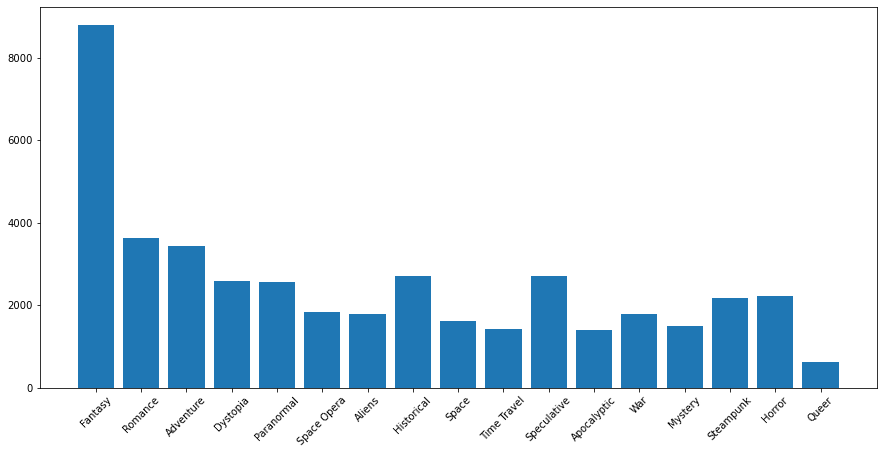

In [93]:
plt.figure(figsize=(15,7))
X = df_genre[genre_list].sum().index
y = df_genre[genre_list].sum()
plt.bar(x=X, height=y)
plt.xticks(rotation=45)
plt.show()

In [94]:
df_g_recent = df_genre[df_genre['Year_published'] >= 2010]
df_g_old = df_genre[df_genre['Year_published'] < 2010]

In [95]:
len(df_g_recent)

6848

In [96]:
df_g_recent['Num_Genres'].mean()

4.025700934579439

In [97]:
df_g_recent['Num_Genres'].median()

4.0

In [98]:
df_g_old['Num_Genres'].mean()

3.6296384965286093

In [99]:
df_g_old['Num_Genres'].median()

4.0

<AxesSubplot:>

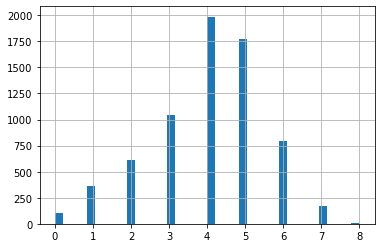

In [100]:
df_g_recent['Num_Genres'].hist(bins='auto')

<AxesSubplot:>

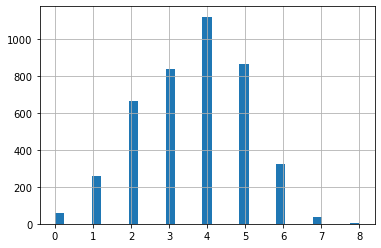

In [101]:
df_g_old['Num_Genres'].hist(bins='auto')

In [ ]:
spacy_mstop = TextSet(df_genre['Book_Description'], 
                     df_genre[genre_list], 
                     name='SpaCy_mstop', multi_label=True,
                     is_spacy=True)

In [ ]:
tf_300_mstop = TextSet(X=df_genre['Book_Description'], 
                       y=df_genre[genre_list],
                       name='tf_300_mstop',
                       is_spacy=False, multi_label=True,
                       keep_stopwords=False)

In [ ]:
tf_400_mstop = TextSet(X=df_genre['Book_Description'], 
                       y=df_genre[genre_list],
                       name='tf_400_mstop',
                       is_spacy=False, multi_label=True,
                       keep_stopwords=False)

In [ ]:
tf_400_2_mstop = TextSet(X=df_genre['Book_Description'], 
                      y=df_genre[genre_list],
                      name='count_mstop',
                      is_spacy=False, multi_label=True,
                      keep_stopwords=False)

In [ ]:
spacy_mstop.vectorize()
tf_300_mstop.vectorize(max_features=300)
tf_400_mstop.vectorize(max_features=400)
tf_400_2_mstop.vectorize(max_features=400, ngram_range=(1,2))

In [ ]:
data_mstop = [spacy_mstop, tf_300_mstop, tf_400_mstop, tf_400_2_mstop]

### Next Steps

- Second, Clean Notebook
- Refine Pre-processing
- Remove low-reviewed books
- Practice Similarity Functions to play with Recommender
- Stacked Classifiers
- Streamlit App

In [ ]:
rf_pipe_genre_5 = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

grid_genre_5 = {
    'rf__n_estimators': [100, 200],
    'rf__criterion' : ['gini','entropy'],
    'rf__max_depth': [25, 50, 75],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [2, 5]
}

rf_grid_genre_5 = GridSearchCV(rf_pipe_genre_5, param_grid=grid_genre_5, scoring='f1_samples',cv=5)
rf_compare_genre_5 = ModelComparison(pipeline=rf_grid_genre_5, data_list=data_mstop, y_format='multi_label',name='rf_genre_5')

In [ ]:
rf_compare_genre_5.fit_models()
rf_compare_genre_5.score_comparison

In [ ]:
rf_compare_genre_5.calc_scores(data_type='holdout')
rf_compare_genre_5.score_comparison

In [ ]:
rf_compare_genre_5.all_scores

In [248]:
rf_pipe_genre_6 = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

grid_genre_6 = {
    'rf__n_estimators': [100, 200, 250],
    'rf__criterion' : ['gini','entropy'],
    'rf__max_depth': [10, 25, 50, 75],
    'rf__min_samples_split': [2, 4, 5],
    'rf__min_samples_leaf': [2, 4, 5]
}

rf_grid_genre_6 = GridSearchCV(rf_pipe_genre_6, param_grid=grid_genre_6, scoring='accuracy',cv=5)
rf_compare_genre_6 = ModelComparison(pipeline=rf_grid_genre_6, data_list=[tf_400_mstop], y_format='multi_label',name='rf_genre_5')

In [249]:
rf_compare_genre_6.fit_models()
rf_compare_genre_6.score_comparison

--- 5182.9909501075745 seconds to process ---


,tf_400_mstop Test
Accuracy,0.045430
Precision (Macro),0.821513
Precision (Micro),0.809080
Recall (Macro),0.242097
Recall (Micro),0.375777
F1 (Micro),0.513199
F1 (Macro),0.321163
F1 (Samples),0.472631
Hamming-Loss,0.167785


In [250]:
rf_compare_genre_6.calc_scores(data_type='holdout')
rf_compare_genre_6.score_comparison

,tf_400_mstop Holdout
Accuracy,0.035036
Precision (Macro),0.709173
Precision (Micro),0.803187
Recall (Macro),0.230221
Recall (Micro),0.366412
F1 (Micro),0.503245
F1 (Macro),0.306621
F1 (Samples),0.466032
Hamming-Loss,0.170889


In [251]:
vectorizer = tf_400_mstop.vectorizor

In [336]:
x = "Six days ago, astronaut Mark Watney became one of the first people to walk on Mars. Now, he’s sure he’ll be the first person to die there. After a dust storm nearly kills him and forces his crew to evacuate while thinking him dead, Mark finds himself stranded and completely alone with no way to even signal Earth that he’s alive—and even if he could get word out, his supplies would be gone long before a rescue could arrive. Chances are, though, he won’t have time to starve to death. The damaged machinery, unforgiving environment, or plain-old “human error” are much more likely to kill him first. But Mark isn’t ready to give up yet. Drawing on his ingenuity, his engineering skills — and a relentless, dogged refusal to quit — he steadfastly confronts one seemingly insurmountable obstacle after the next. Will his resourcefulness be enough to overcome the impossible odds against him?"

In [252]:
vectorizer

TfidfVectorizer(max_features=400)

In [304]:
x = "The clone special unit called 'The Bad Batch' consists of clones with helpful side effects, such as super strength, make their way through the newly founded empire and trying to find out why all clone troops, except themselves, opposed their jedi generals."

In [337]:
x

'Six days ago, astronaut Mark Watney became one of the first people to walk on Mars. Now, he’s sure he’ll be the first person to die there. After a dust storm nearly kills him and forces his crew to evacuate while thinking him dead, Mark finds himself stranded and completely alone with no way to even signal Earth that he’s alive—and even if he could get word out, his supplies would be gone long before a rescue could arrive. Chances are, though, he won’t have time to starve to death. The damaged machinery, unforgiving environment, or plain-old “human error” are much more likely to kill him first. But Mark isn’t ready to give up yet. Drawing on his ingenuity, his engineering skills — and a relentless, dogged refusal to quit — he steadfastly confronts one seemingly insurmountable obstacle after the next. Will his resourcefulness be enough to overcome the impossible odds against him?'

In [338]:
tokens = process_text(x, keep_stopwords=False)

In [339]:
' '.join(tokens)

'six days ago astronaut mark watney became one first people walk mars ’s sure ’ll first person die dust storm nearly kills forces crew evacuate thinking dead mark finds stranded completely alone way even signal earth ’s alive even could get word supplies would gone long rescue could arrive chances though wo n’t time starve death damaged machinery unforgiving environment plain old human error much likely kill first mark n’t ready give yet drawing ingenuity engineering skills relentless dogged refusal quit steadfastly confronts one seemingly insurmountable obstacle next resourcefulness enough overcome impossible odds'

In [340]:
vector = vectorizer.transform([' '.join(tokens)])

In [341]:
vector

<1x400 sparse matrix of type '<class 'numpy.float64'>'
	with 37 stored elements in Compressed Sparse Row format>

In [353]:
predict = rf_compare_genre_6.pipeline.predict_proba(vector.toarray())

In [358]:
predict[0][0][1]

0.8009956181360374

In [360]:
score_dict = {}

for (n, genre) in enumerate(genre_list):
    score_dict[genre] = predict[n][0][1]

{k: v for k, v in sorted(score_dict.items(), key=lambda item: item[1], reverse=True)}

{'Fantasy': 0.8009956181360374,
 'Adventure': 0.5634912347229287,
 'Space': 0.46929027438490395,
 'Horror': 0.4113244638399625,
 'Romance': 0.24787778445575584,
 'Space Opera': 0.2209857546593916,
 'Paranormal': 0.18125013228273512,
 'War': 0.17488576415686033,
 'Aliens': 0.16941339052331686,
 'Dystopia': 0.15441590326547058,
 'Steampunk': 0.13897999109674508,
 'Speculative': 0.1348574011262927,
 'Historical': 0.1073180905119151,
 'Mystery': 0.1048881258195507,
 'Apocalyptic': 0.10393988996090858,
 'Time Travel': 0.04847660158754504,
 'Queer': 0.045424891565080026}

In [344]:
predict

array([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [345]:
pd.DataFrame(predict, columns=genre_list)

,Fantasy,Romance,Adventure,Dystopia,Paranormal,Space Opera,Aliens,Historical,Space,Time Travel,Speculative,Apocalyptic,War,Mystery,Steampunk,Horror,Queer
0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [361]:
final_pipeline = rf_compare_genre_6.pipeline

In [325]:
x = df_desc['Book_Description'].iloc[30]

In [526]:
def print_genre_scores(description):
    
    tokens = process_text(description, keep_stopwords=False)
    
    vector = vectorizer.transform([' '.join(tokens)])
    
    predict = new_model.predict_proba(vector.toarray())
    
    score_dict = {}

    for (n, genre) in enumerate(genre_list):
        score_dict[genre] = predict[n][0][1]

    final_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda item: item[1], reverse=True)}
    
    df = pd.DataFrame.from_dict([final_dict]).T
    
    df.columns = ['Probabilities']
    
    return df

In [368]:
y = "The Three-Body Problem is the first chance for English-speaking readers to experience the Hugo Award-winning phenomenon from China's most beloved science fiction author, Liu Cixin.Set against the backdrop of China's Cultural Revolution, a secret military project sends signals into space to establish contact with aliens. An alien civilization on the brink of destruction captures the signal and plans to invade Earth. Meanwhile, on Earth, different camps start forming, planning to either welcome the superior beings and help them take over a world seen as corrupt, or to fight against the invasion. The result is a science fiction masterpiece of enormous scope and vision. "

In [369]:
print_genre_scores(y)

{'Fantasy': 0.6987296626232383,
 'Aliens': 0.5521168527894534,
 'Space': 0.41409004613377676,
 'Space Opera': 0.38567988289660105,
 'War': 0.36836275197111107,
 'Romance': 0.3132584229495995,
 'Adventure': 0.3089788792648701,
 'Speculative': 0.25865018224809244,
 'Paranormal': 0.19602941176470587,
 'Dystopia': 0.13577662615162614,
 'Horror': 0.10991345582522052,
 'Historical': 0.08054847766612473,
 'Mystery': 0.0800015293014519,
 'Queer': 0.07986025713192897,
 'Apocalyptic': 0.051528138528138534,
 'Time Travel': 0.04703298090798091,
 'Steampunk': 0.0335094905094905}

In [371]:
df_new['Age_Group'].value_counts(normalize=True)

Adult          0.701146
Young Adult    0.232788
Children       0.066066
Name: Age_Group, dtype: float64

In [374]:
tf_400_age = TextSet(X=df_new['Book_Description'],
                 y=df_new['Age_Group'],
                 name='tf_400_age',
                 is_spacy=False, multi_label=False,
                 keep_stopwords=False)

--- 240.4398159980774 seconds ---


In [378]:
tf_400_age.vectorize(max_features=400)

In [388]:
svm_pipe_age = Pipeline([('scaler', StandardScaler()), ('rbf',svm.SVC(probability=True))])

grid_age = {
    'rbf__kernel':['rbf','sigmoid'],
    'rbf__gamma' :['scale','auto'],
    'rbf__C': [1, 100, 1e12],
    'rbf__decision_function_shape': ['ovo','ovr']
}

svm_grid_age = GridSearchCV(svm_pipe_age, param_grid=grid_age, scoring='f1_score',cv=5)
svm_compare_age = ModelComparison(pipeline=svm_pipe_age, data_list=[tf_400_age], y_format='label',name='svm_age')

In [389]:
svm_compare_age.fit_models()
svm_compare_age.score_comparison

--- 65.07156300544739 seconds to process ---


,tf_400_age Test
Accuracy,0.757414
Precision (Macro),0.698470
Recall (Macro),0.491518
F1 (Macro),0.526500


In [390]:
svm_compare_age.calc_scores(data_type='holdout')
svm_compare_age.score_comparison

,tf_400_age Holdout
Accuracy,0.794444
Precision (Macro),0.792355
Recall (Macro),0.528762
F1 (Macro),0.585242


In [382]:
age_vector = tf_400_age.vectorizor

In [391]:
age_model = svm_compare_age.pipeline

In [409]:
age_groups = ['Adult', 'Children', 'Young Adult']

In [433]:
def print_age_scores(description):
    
    tokens = process_text(description, keep_stopwords=False)
    
    vector = age_vector.transform([' '.join(tokens)])
    
    predict = age_model.predict_proba(vector.toarray())
    
    score_dict = {}

    for (n, genre) in enumerate(age_groups):
        score_dict[genre] = predict[0][n]

    final_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda item: item[1], reverse=True)}
    
    df = pd.DataFrame.from_dict([final_dict]).T
    
    df.columns = ['Probabilities']
    
    return df

In [411]:
z = "Kira Navárez dreamed of life on new worlds. Now she's awakened a nightmare. During a routine survey mission on an uncolonized planet, Kira finds an alien relic. At first she's delighted, but elation turns to terror when the ancient dust around her begins to move.As war erupts among the stars, Kira is launched into a galaxy-spanning odyssey of discovery and transformation. First contact isn't at all what she imagined, and events push her to the very limits of what it means to be human.While Kira faces her own horrors, Earth and its colonies stand upon the brink of annihilation. Now, Kira might be humanity's greatest and final hope... "

In [407]:
tokens = process_text(z, keep_stopwords=False)
vector = age_vector.transform([' '.join(tokens)])
predict = age_model.predict_proba(vector.toarray())

In [414]:
predict[0][1]

0.004114460478044995

In [400]:
label = tf_400_age.y_labeler

In [401]:
tf_400_age.y_labeler

LabelEncoder()

In [406]:
label.inverse_transform(np.array([2]))

array(['Young Adult'], dtype=object)

In [422]:
pd.DataFrame.from_dict([print_age_scores(q)])

,Young Adult,Children,Adult
0,0.894216,0.054735,0.051049


In [421]:
q = "One teen’s incredible journey may just blow his father’s mind… Fourteen-year-old Bernard thinks outside the box. The only problem is that neither his school nor his ultra-rational physicist father appreciate his unique ideas. When he reacts to a stressful situation at school by mooning the class, his suspension sends him straight to his father’s workplace. After his frustrated father leaves him unattended, Bernard does what any teen would do: wander into the particle accelerator and accidentally get transported through a wormhole! It doesn’t take long for Bernard to realize he’s in deep trouble. Not only did the wormhole drop him in the middle of a civil war over a depleted resource, but the battle is actually taking place inside his father’s brain. Bernard has one chance to save the dying side of his father’s creative brain from the tyrannical left side. Can he use his outside-the-box thinking to save his father’s life? Brainwalker is a young adult sci-fi fantasy novel that turns the world of neuroscience on its head. If you like incredible fantasy worlds, fast-paced entertainment, and the human mind, then you’ll love Robyn Mundell and Stephan Lacast’s amazing journey inside the brain. Buy Brainwalker to help the mind survive today!"

In [435]:
print_genre_scores(q)

,Probabilities
Fantasy,0.771559
Romance,0.567881
Dystopia,0.387796
Paranormal,0.330873
Horror,0.279025
Adventure,0.270621
Steampunk,0.188702
Mystery,0.182085
Historical,0.176853
Speculative,0.162839


In [436]:
print_age_scores(q)

,Probabilities
Young Adult,0.894216
Children,0.054735
Adult,0.051049


In [437]:
b = "Arcadium I is the science fiction retelling of Shakespeare's Henry IV Part I. It tells the story of the ascension of an underestimated ruler by way of brutal violence, self-discovery, and strategic brilliance.  Five hundred years after humans have fled a decaying Earth, they have settled on two planets in a solar system: the jungle planet Arcadia and an ice planet Avalon. Arcadia, a planet plagued with income inequality, terrorist attacks, political strife, and failing infrastructure, is kept under the heel of the technologically superior Avalon, forced to send shipments of food every two years whenever the planets fall into a similar orbit. If the shipments don't come, Avalon attacks and Avalon always wins. Helyn Pilot is second in line for the Arcadian throne. She's brilliant and passionate, but utterly under-utilized by her family as a vapid tabloid target. At 22 years old, she is perceived as little more than a party girl whose closest relationship is with her drug dealer, the war hero and night club owner, Jack Stafford. Her addictions and her reputation destroy her arranged marriage with the Avalonian heir and with it, their only chance for peace. In the explosive aftermath, Helyn is thrust into the darkest jungles and is forced to fight her way out. Enemies and espionage surround her as she runs from terrorist groups and Avalonian agents. Though experiencing serious drug withdrawal, she survives, thrives, and manipulates her enemies' misconceptions of her in order to politically and physically out-maneuver them at every turn. Arcadium I is the first part of a trilogy that follows the trajectory of Shakespeare's Henriad, culminating in the massive and all-out invasion depicted in Henry V. I have completed full outlines for the following two installments. It is similar in tone and the shifts in perspective found in George R.R. Martin's A Song of Ice and Fire while also sticking close to the grinding tension and intrigue of 1970s political thrillers like The Parallax View or Three Days of the Condor."

In [438]:
print_genre_scores(b)

,Probabilities
Fantasy,0.651974
Aliens,0.367928
Romance,0.296358
Space,0.291614
War,0.285311
Adventure,0.260405
Space Opera,0.240185
Speculative,0.228382
Dystopia,0.203918
Horror,0.175494


In [439]:
print_age_scores(b)

,Probabilities
Adult,0.709518
Young Adult,0.267373
Children,0.023109


In [440]:
s = "In Septimus Salt, a boy grows from adolescence and into old age as he attempts the impossible: to sail to the moon. Eventually, he is forced to come to terms with the fact that his dreams may never come to pass and that he might have thrown his life away chasing a fairy tale. At what point do you give up and head back? Or do you just keep sailing into the storm and hope for the best?Septimus Salt follows one man’s life, from humble beginnings on the island of Evermore in the Infinite Sea, surrounded by aquaphobes and false intellectuals.  He follows in the footsteps of great sailors who attempted and failed before him, completely unaware of the myriad dangers that await him in the lonely waters: hunger, thirst, thieves, lost love, monsters in the dark, and the sea itself (as well as some goop that turns him into a chicken at one point). The story begins in the Young Adult vein of The Little Prince or A Wrinkle in Time but as Septimus ages and his adventures grow darker and more sinister, the story falls into the whimsical danger of Ray Bradbury or Susanna Clarke. "

In [442]:
print_age_scores(s)

,Probabilities
Adult,0.635725
Young Adult,0.321215
Children,0.043060


In [446]:
from sklearn.metrics.pairwise import cosine_similarity

In [448]:
vectorizer = tf_400_mstop.vectorizor

In [450]:
df_pop = df_desc[df_desc['Review_number'] >= 55]

In [451]:
def create_vector(x):
    
    tokens = process_text(x, keep_stopwords=False)
    vector = vectorizer.transform([' '.join(tokens)])
    
    return vector.toarray()

In [452]:
df_pop['Vector'] = df_pop['Book_Description'].map(lambda x: create_vector(x))

In [458]:
tokens = process_text(b, keep_stopwords=False)
    
vector = vectorizer.transform([' '.join(tokens)]).toarray()

In [459]:
cosine_similarity(vector, df_pop['Vector'].iloc[0])

array([[0.09825615]])

In [511]:
def find_most_similar(description):
    
    vector = create_vector(description)
    
    df_vectors['Similarity'] = df_vectors['Vector'].map(lambda x: cosine_similarity(vector, x)[0][0])
    
    df_final = df_vectors.sort_values(by=['Similarity'], ascending=False)
    
    df_final.drop(columns=['Vector'],inplace=True)
    
    return df_final.head(10)
    

In [461]:
df_pop.columns

Index(['Book_Title', 'Original_Book_Title', 'Author_Name', 'Edition_Language',
       'Rating_score', 'Rating_votes', 'Review_number', 'Book_Description',
       'Year_published', 'Genres', 'url', 'aliens', 'alternate_history',
       'alternate_universe', 'apocalyptic', 'cyberpunk', 'dystopia', 'hard',
       'military', 'robots', 'space_opera', 'steampunk', 'time_travel',
       'Num_Genres', 'genres', 'Age_Group', 'Genre_Set', 'Vector'],
      dtype='object')

In [499]:
df_vectors = df_pop[['Book_Title','Author_Name', 'Year_published', 'Book_Description', 'Vector','Rating_votes','Review_number','Rating_score','Age_Group']]

In [464]:
df_vectors.sort_values(by='Book_Title',ascending=False)

,Book_Title,Author_Name,Year_published,Vector
3242,魔道祖师 [Mo Dao Zu Shi,墨香铜臭,2015,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5857,進撃の巨人 9 [Shingeki no Kyojin 9,Hajime Isayama,2012,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5892,進撃の巨人 8 [Shingeki no Kyojin 8,Hajime Isayama,2012,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5840,進撃の巨人 7 [Shingeki no Kyojin 7,Hajime Isayama,2012,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5891,進撃の巨人 10 [Shingeki no Kyojin 10,Hajime Isayama,2013,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...
3796,14,Peter Clines,2012,"[[0.1763959781031556, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3839,12.21,Dustin Thomason,2012,"[[0.1435788671013963, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1257,11/22/63,Stephen King,2011,"[[0.0, 0.0, 0.0, 0.0, 0.1589671228146994, 0.0,..."
3727,100 Days in Deadland,Rachel Aukes,2013,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [474]:
find_most_similar(b)

,Book_Title,Author_Name,Year_published,Vector,Similarity
483,Out of the Silent Planet,C.S. Lewis,1938,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[[0.3547531743840893]]
7089,War Dogs,Greg Bear,2014,"[[0.0, 0.0, 0.0, 0.0, 0.1756402100776822, 0.0,...",[[0.34384161549909137]]
7851,Liege-Killer,Christopher Hinz,1987,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[[0.33917929437630684]]
7049,A Desert Called Peace,Tom Kratman,2007,"[[0.15060419143843717, 0.0, 0.0, 0.0, 0.0, 0.0...",[[0.33166830761585725]]
1095,Hers to Command,Patricia A. Knight,2013,"[[0.0, 0.0, 0.0, 0.0, 0.1463446239660134, 0.0,...",[[0.33126726071029344]]
942,Unnatural,Alessandra Hazard,2020,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[[0.32953457707617007]]
2052,Time's Eye,Arthur C. Clarke,2003,"[[0.09290846824169793, 0.0, 0.0, 0.0, 0.0, 0.0...",[[0.3248571712034848]]
209,Fuzzy Nation,John Scalzi,2011,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[[0.3122781977730694]]
8640,Transformers: Exodus: The Official History of ...,Alexander C. Irvine,2010,"[[0.0, 0.13592456616327678, 0.0, 0.15244860223...",[[0.3108143922866511]]
4788,The Girl Who Played with Fire,Stieg Larsson,2006,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[[0.30610003335121955]]


In [475]:
martian = "Six days ago, astronaut Mark Watney became one of the first people to walk on Mars. Now, he’s sure he’ll be the first person to die there. After a dust storm nearly kills him and forces his crew to evacuate while thinking him dead, Mark finds himself stranded and completely alone with no way to even signal Earth that he’s alive—and even if he could get word out, his supplies would be gone long before a rescue could arrive. Chances are, though, he won’t have time to starve to death. The damaged machinery, unforgiving environment, or plain-old “human error” are much more likely to kill him first. But Mark isn’t ready to give up yet. Drawing on his ingenuity, his engineering skills — and a relentless, dogged refusal to quit — he steadfastly confronts one seemingly insurmountable obstacle after the next. Will his resourcefulness be enough to overcome the impossible odds against him?"

In [476]:
find_genre(martian)

[]

In [478]:
print_age_scores(martian)

,Probabilities
Adult,0.896842
Young Adult,0.099867
Children,0.003291


In [483]:
m_guess = find_most_similar(martian)

In [488]:
m_guess['Book_Description'].iloc[4]

"Andi was doing just fine on her own. Sure the world had been hit with an outbreak that turned anyone infected into flesh eating zombies. Not to mention that everyone she ever loved was now dead. She was alive though, taking care of herself. She had little desire to indulge in building relationships with anyone. People just couldn't be trusted. Whether they screwed you over intentionally, or just managed to get themselves killed, no one stuck around for very long. She didn't need anyone else either. That was until Will showed up to save her. Will, with his sparkling green eyes, lips you just wanted to taste, and insanely adorable crooked smile, wasn't letting Andi get rid of him so easily. Yet still, Andi did everything she could to push her feelings, and Will, away. The more time they spent together though, the more difficult that became. In a world where another day was not something you could count on, wasting even a single moment, could mean missing out on your only chance for happ

In [491]:
arcadium = b

In [501]:
arcadium_df = find_most_similar(arcadium)

In [498]:
arcadium_df['Book_Description'].iloc[3]

"Five hundred years from now, humankind has found a link to a remarkably Earth-like planet and settled there, dividing as humans will -- into dozens of nation-states. The Federated States of Columbia has consolidated power and risen against the oppression of Earth's corrupt Caliphate. But when Salafi madmen bent on a new jihad kill FSC Captain Patrick Hennessey's family in a cowardly attack, they create an enemy that will show even less mercy than they do.A legendary warrior is born: Carrera, the scourge of Salafism. He will forge an army from the decrepit remains of a military in a failing state. He will find those who killed his family. He will destroy them utterly. And he will try like hell to not becoming exactly like the enemy he is fighting. Only when he is finished will there be peace: the peace of an empty wind as it blows across a desert strewn with the bones of Carrera's enemies."

In [502]:
arcadium_df

,Book_Title,Author_Name,Year_published,Book_Description,Rating_votes,Review_number,Rating_score,Age_Group,Similarity
483,Out of the Silent Planet,C.S. Lewis,1938,In the first novel of C.S. Lewis's classic sci...,78248,4027,3.91,Adult,[[0.3547531743840893]]
7089,War Dogs,Greg Bear,2014,AN EPIC INTERSTELLAR TALE OF WAR FROM A MASTER...,2209,261,3.39,Adult,[[0.34384161549909137]]
7851,Liege-Killer,Christopher Hinz,1987,Two hundred years after Earth is devastated by...,915,59,4.22,Adult,[[0.33917929437630684]]
7049,A Desert Called Peace,Tom Kratman,2007,"Five hundred years from now, humankind has fou...",2030,83,3.80,Adult,[[0.33166830761585725]]
1095,Hers to Command,Patricia A. Knight,2013,"For some, existence without their mate might s...",1050,169,3.66,Adult,[[0.33126726071029344]]
942,Unnatural,Alessandra Hazard,2020,A planet at war. Two alphas forced into a poli...,2349,344,4.12,Adult,[[0.32953457707617007]]
2052,Time's Eye,Arthur C. Clarke,2003,"Sir Arthur C. Clarke is a living legend, a wri...",6653,361,3.72,Adult,[[0.3248571712034848]]
209,Fuzzy Nation,John Scalzi,2011,"Jack Holloway works alone, for reasons he does...",29984,2540,4.11,Adult,[[0.3122781977730694]]
8640,Transformers: Exodus: The Official History of ...,Alexander C. Irvine,2010,For twenty-five years the colossal battle bet...,1061,110,4.08,Adult,[[0.3108143922866511]]
4788,The Girl Who Played with Fire,Stieg Larsson,2006,"Part blistering espionage thriller, part rivet...",825340,34441,4.24,Adult,[[0.30610003335121955]]


In [512]:
sep = find_most_similar(s)

In [510]:
sep['Similarity'].iloc[0][0][0]

0.4132662034292953

In [513]:
sep

,Book_Title,Author_Name,Year_published,Book_Description,Rating_votes,Review_number,Rating_score,Age_Group,Similarity
9531,Clockwork,Philip Pullman,1996,"Fritz, the writer, spins a spine-tingling tale...",6753,725,3.87,Children,0.413266
11077,The Lost Prince,Selden Edwards,2012,From the author of the beloved New York Times ...,692,147,3.50,Adult,0.370274
418,Once Upon a Time,Alessandra Hazard,2019,"A very proper prince and a rude, dangerous man...",2395,303,4.31,Adult,0.355498
867,From a Distant Star,Karen McQuestion,2015,Seventeen-year-old Emma was the only one who h...,2422,532,3.88,Young Adult,0.333279
2179,City of Masks,Mary Hoffman,2002,Lucien is seriously ill but his life is transf...,15505,656,3.92,Children,0.330773
10266,The Mine,John A. Heldt,2012,"In May 2000, Joel Smith is a cocky, adventurou...",2119,468,4.03,Young Adult,0.328709
10834,The Ugly Little Boy,Isaac Asimov,1991,"Asimov wrote the short story ""The Ugly Little ...",3021,143,3.88,Adult,0.321475
10080,Baba Ali and the Clockwork Djinn: A Steampunk ...,Danielle Ackley-McPhail,2014,"Come, Best Beloved, and sit you by my feet. I ...",97,68,4.22,Adult,0.306577
10956,Q,Evan Mandery,2011,"“A philosophical, witty, wonderful, and altoge...",1280,288,3.21,Adult,0.304602
2988,The Time Traveler's Wife,Audrey Niffenegger,2003,"A funny, often poignant tale of boy meets girl...",1604679,47708,3.98,Adult,0.304390


In [514]:
arcadium

"Arcadium I is the science fiction retelling of Shakespeare's Henry IV Part I. It tells the story of the ascension of an underestimated ruler by way of brutal violence, self-discovery, and strategic brilliance.  Five hundred years after humans have fled a decaying Earth, they have settled on two planets in a solar system: the jungle planet Arcadia and an ice planet Avalon. Arcadia, a planet plagued with income inequality, terrorist attacks, political strife, and failing infrastructure, is kept under the heel of the technologically superior Avalon, forced to send shipments of food every two years whenever the planets fall into a similar orbit. If the shipments don't come, Avalon attacks and Avalon always wins. Helyn Pilot is second in line for the Arcadian throne. She's brilliant and passionate, but utterly under-utilized by her family as a vapid tabloid target. At 22 years old, she is perceived as little more than a party girl whose closest relationship is with her drug dealer, the war

In [516]:
print_genre_scores(arcadium)

,Probabilities
Fantasy,0.651974
Aliens,0.367928
Romance,0.296358
Space,0.291614
War,0.285311
Adventure,0.260405
Space Opera,0.240185
Speculative,0.228382
Dystopia,0.203918
Horror,0.175494


In [518]:
df = find_most_similar(arcadium)

"AN EPIC INTERSTELLAR TALE OF WAR FROM A MASTER OF SCIENCE FICTION.One more tour on the red. Maybe my last.They made their presence on Earth known thirteen years ago.Providing technology and scientific insights far beyond what mankind was capable of. They became indispensable advisors and promised even more gifts that we just couldn't pass up. We called them Gurus.It took them a while to drop the other shoe. You can see why, looking back.It was a very big shoe, completely slathered in crap.They had been hounded by mortal enemies from sun to sun, planet to planet, and were now stretched thin -- and they needed our help.And so our first bill came due. Skyrines like me were volunteered to pay the price. As always.These enemies were already inside our solar system and were moving to establish a beachhead, but not on Earth.On Mars."

In [ ]:
final_pipeline.

In [522]:
import pickle

In [523]:
filename = 'genre_model.sav'

In [531]:
filename_2 = 'age_model.sav'

In [529]:
pickle.dump(final_pipeline, open(filename, 'wb'))

In [532]:
pickle.dump(age_model, open(filename_2, 'wb'))

In [525]:
new_model = pickle.load(open(filename, 'rb'))

In [527]:
print_genre_scores(arcadium)

,Probabilities
Fantasy,0.651974
Aliens,0.367928
Romance,0.296358
Space,0.291614
War,0.285311
Adventure,0.260405
Space Opera,0.240185
Speculative,0.228382
Dystopia,0.203918
Horror,0.175494
